# Technical Report - Rappi Challenge

Gabriel de Oliveira Sobrinho



In [3]:
pip install jupyterlab
pip install nbconvert


SyntaxError: invalid syntax (2176434930.py, line 1)

In [3]:
# ⢀⣠⣄⡀⠀⠀⠀⣠⣶⣾⣿⣿⣶⣦⣴⣾⣿⣿⣷⣦⣄⠀⠀⠀⢀⣠⣄⡀⠀
#⣰⣿⠟⠛⢻⡆⣠⣾⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣷⡄⢰⠟⠛⢻⣿⡆
#⢻⣿⣦⣀⣤⣾⣿⣿⣿⣿⣿⣿⠟⠋⠀⠀⠙⠿⣿⣿⣿⣿⣿⣿⣦⣤⣀⣼⣿⡇
#⠀⠛⠿⢿⣿⣿⡿⠿⠟⠛⠉⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⠿⠿⢿⣿⣿⡿⠿⠋⠀

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Automated EDA
import sweetviz as sv

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, confusion_matrix, classification_report, 
                             precision_recall_curve, average_precision_score)
from xgboost import XGBClassifier

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, ADASYN

# IPython Display
from IPython.display import Image
from IPython.core.display import HTML

# Clustering
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, auc, matthews_corrcoef
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt



In [2]:
#Functions and Definitions

database_path = r'C:\Users\g00839270\Downloads\Personal Files\Rappi\orders (2022).csv'

rappi_colors = [
    "#f5a16c", "#f28268", "#ef6564", "#ec525c", "#ea3f53", "#e92e4b",
    '#FE7962', '#FF4C45', '#F2685C', '#241F99', '#FF4552', '#A7E083'
]

def bin_definer(df, column, n_quantile_bins=7, max_kmeans_clusters=10):
    # Quantile Binning
    quantile_bins = pd.qcut(df[column], q=n_quantile_bins, duplicates='drop')
    quantile_labels = quantile_bins.cat.categories
    
    # K-means Clustering for Binning
    scaler = StandardScaler()
    column_scaled = scaler.fit_transform(df[[column]])
    
    # Determine the optimal number of clusters using the elbow method
    wcss = []
    for i in range(1, max_kmeans_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(column_scaled)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow method result
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_kmeans_clusters + 1), wcss, marker='o')
    plt.title(f'Elbow Method for Optimal Clusters for {column}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    # Fit KMeans with the optimal number of clusters
    optimal_clusters = np.argmax(np.diff(wcss)) + 1
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    df[f'{column}_cluster'] = kmeans.fit_predict(column_scaled)
    
    # Create bin edges and labels
    kmeans_bins = np.linspace(df[column].min(), df[column].max(), optimal_clusters + 1)
    kmeans_labels = [f'Cluster {i+1}' for i in range(optimal_clusters)]
    
    return {
        'quantile_labels': quantile_labels,
        'kmeans_bins': kmeans_bins,
        'kmeans_labels': kmeans_labels
    }
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'


def plot_acceptance_rejection(data, x, ax, title, xlabel):
    # Calculate total orders, acceptance rate, and rejection rate
    stats = data.groupby(x).agg(
        total_orders=('order_id', 'count'),
        acceptance_rate=('taken', 'mean'),
        rejection_rate=('taken', lambda x: 1 - x.mean())
    ).reset_index()

    # Convert bins to string for better labeling
    stats[x] = stats[x].astype(str)

    # Bar plot for total orders
    sns.barplot(x=x, y='total_orders', data=stats, hue=x, palette=rappi_colors[:len(stats)], ax=ax, dodge=False)
    ax.set_ylabel('Total Orders', color='black')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    # Rotate x labels for readability
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    # Create a second y-axis to plot the acceptance and rejection rates
    ax2 = ax.twinx()
    sns.lineplot(x=x, y='acceptance_rate', data=stats, marker='o', color='green', ax=ax2, label='Acceptance Rate')
    sns.lineplot(x=x, y='rejection_rate', data=stats, marker='o', color='red', ax=ax2, label='Rejection Rate')
    ax2.set_ylabel('Rate', color='black')
    ax2.set_ylim(0, 1)

    # Adding legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h1 + h2, l1 + l2, loc='upper left')



def plot_acceptance_rejection_rate(df, combined_feature):
    rate_df = df.groupby([combined_feature, 'taken']).size().unstack(fill_value=0)
    rate_df['total'] = rate_df.sum(axis=1)
    rate_df['acceptance_rate'] = rate_df[1] / rate_df['total']
    rate_df['rejection_rate'] = rate_df[0] / rate_df['total']
    
    rate_df[['acceptance_rate', 'rejection_rate']].plot(kind='bar', stacked=True, figsize=(14, 7), color=['#FF5C4B', '#5204BF'])
    plt.title(f'Acceptance and Rejection Rates by {combined_feature}')
    plt.ylabel('Rate')
    plt.xlabel(combined_feature)
    plt.show()

def add_features(df):
    df = df.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['order_hour'] = df['created_at'].dt.hour
    df['order_dayofweek'] = df['created_at'].dt.dayofweek
    df['earning_per_distance'] = df['total_earning'] / (df['to_user_distance'] + 1e-5)
    df['elevation_change_rate'] = df['to_user_elevation'] / (df['to_user_distance'] + 1e-5)
    return df
# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to train and evaluate model with SMOTE
def train_evaluate_model_with_smote(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_res, y_train_res = apply_smote(X_train, y_train)
    model = XGBClassifier( eval_metric='logloss')
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, marker='.', label='XGBoost')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
def plot_acceptance_rejection(data, x, ax, title, xlabel):
    # Calculate total orders, acceptance rate, and rejection rate
    stats = data.groupby(x).agg(
        total_orders=('order_id', 'count'),
        acceptance_rate=('taken', 'mean'),
        rejection_rate=('taken', lambda x: 1 - x.mean())
    ).reset_index()

    # Convert bins to string for better labeling
    stats[x] = stats[x].astype(str)

    # Bar plot for total orders
    sns.barplot(x=x, y='total_orders', data=stats, palette=rappi_colors[:len(stats)], ax=ax, dodge=False)
    ax.set_ylabel('Total Orders', color='black')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    # Rotate x labels for readability
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    # Create a second y-axis to plot the acceptance and rejection rates
    ax2 = ax.twinx()
    sns.lineplot(x=x, y='acceptance_rate', data=stats, marker='o', color='green', ax=ax2, label='Acceptance Rate')
    sns.lineplot(x=x, y='rejection_rate', data=stats, marker='o', color='red', ax=ax2, label='Rejection Rate')
    ax2.set_ylabel('Rate', color='black')
    ax2.set_ylim(0, 1)

    # Adding legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h1 + h2, l1 + l2, loc='upper left')


def p_value_test(df, target, features, alpha=0.05):
    results = pd.DataFrame(columns=['Feature', 'p-value', 'Significance'])
    for feature in features:
        taken_values = df[df[target] == 1][feature]
        not_taken_values = df[df[target] == 0][feature]
        t_stat, p_val = ttest_ind(taken_values, not_taken_values, equal_var=False)
        significance = 'Significant' if p_val < alpha else 'Not Significant'
        results = pd.concat([results, pd.DataFrame({'Feature': [feature], 'p-value': [p_val], 'Significance': [significance]})], ignore_index=True)
    return results

def chi_squared_test(df, target, features):
    chi2_results = pd.DataFrame(columns=['Feature', 'p-value', 'Significance'])
    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target])
        _, p_val, _, _ = chi2_contingency(contingency_table)
        significance = 'Significant' if p_val < 0.05 else 'Not Significant'
        chi2_results = pd.concat([chi2_results, pd.DataFrame({'Feature': [feature], 'p-value': [p_val], 'Significance': [significance]})], ignore_index=True)
    return chi2_results

def mutual_info_test(df, target, features):
    mi_results = pd.DataFrame(columns=['Feature', 'MI Score'])
    X = df[features]
    y = df[target]
    mi_scores = mutual_info_classif(X, y)
    mi_results['Feature'] = features
    mi_results['MI Score'] = mi_scores
    return mi_results

def check_inconsistencies(df, categorical_columns):
    inconsistencies = {
        'missing_values': {},
        'invalid_entries': {},
        'empty_values': {},
        'non_numeric_values': {}
    }
    
    for column in df.columns:
        # Missing values
        inconsistencies['missing_values'][column] = df[column].isnull().sum()
        
        # Invalid entries specific to 'total_earning'
        if column == 'total_earning' and df[column].dtype == object:
            inconsistencies['invalid_entries'][column] = df[column].str.contains(' - ').sum()
        else:
            inconsistencies['invalid_entries'][column] = 0
        
        # Empty values
        inconsistencies['empty_values'][column] = (df[column].astype(str).str.strip() == '').sum()
        
        # Non-numeric values
        if column in categorical_columns:
            inconsistencies['non_numeric_values'][column] = df[column].apply(lambda x: isinstance(x, (int, float))).sum()
        else:
            non_numeric_mask = pd.to_numeric(df[column], errors='coerce').isnull()
            inconsistencies['non_numeric_values'][column] = non_numeric_mask.sum()
    
    return inconsistencies

def plot_numerical_distributions(df, numerical_columns):
    for column in numerical_columns:
        plt.figure(figsize=(10, 6))
        df[column].hist(bins=50)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.show()
        
def clean_column(df, column_name):
    # Convert to string for initial cleaning
    df[column_name] = df[column_name].astype(str)
    # Remove empty values
    df = df[df[column_name].str.strip() != '']
    # Remove currency symbols or other unwanted characters
    df[column_name] = df[column_name].str.replace('[\$,]', '', regex=True).str.strip()
    # Convert back to numeric, allowing for decimal points and negative values
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    # Handle missing values by filling with mean
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    return df

def clean_all_columns(df, exclude_columns):
    for column in df.columns:
        if column not in exclude_columns:
            df = clean_column(df, column)
    return df


def visualize_distributions(df, columns, title_prefix):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column], bins=50, kde=True)
        plt.title(f'{title_prefix} Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

                                             |          | [  0%]   00:00 -> (? left)


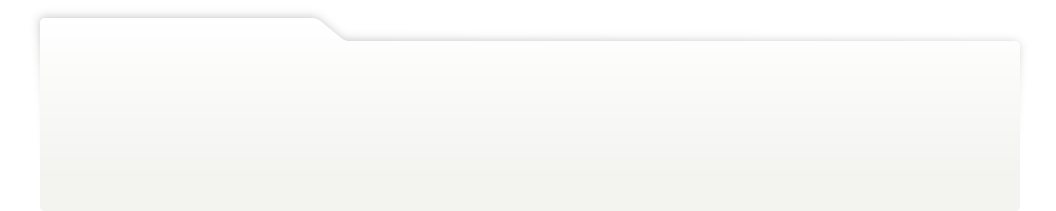
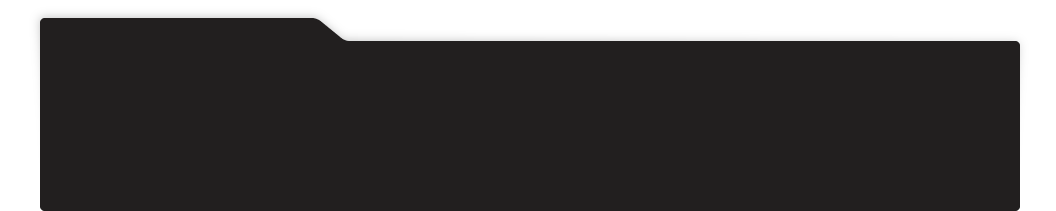
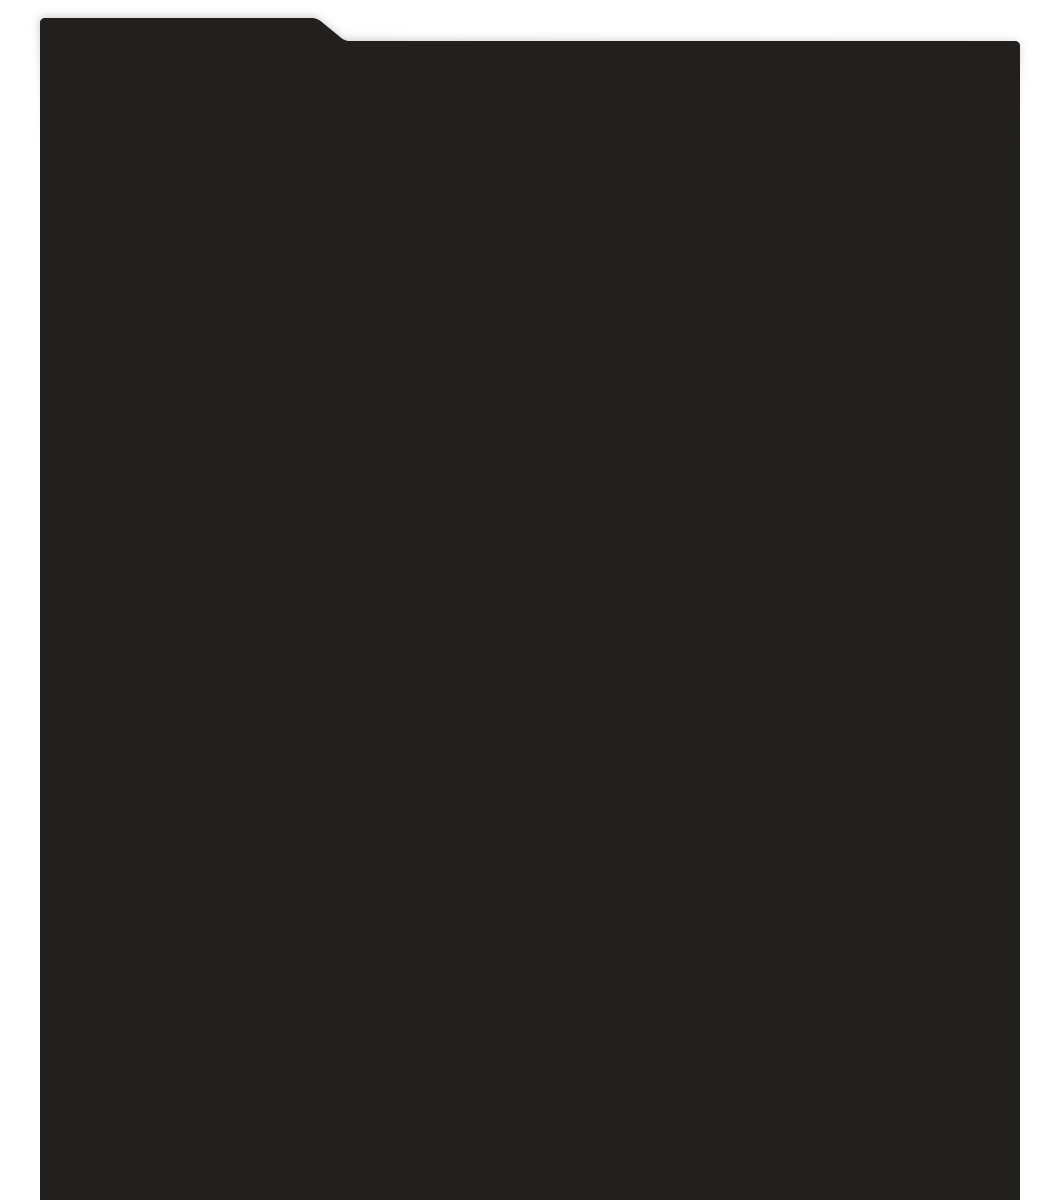
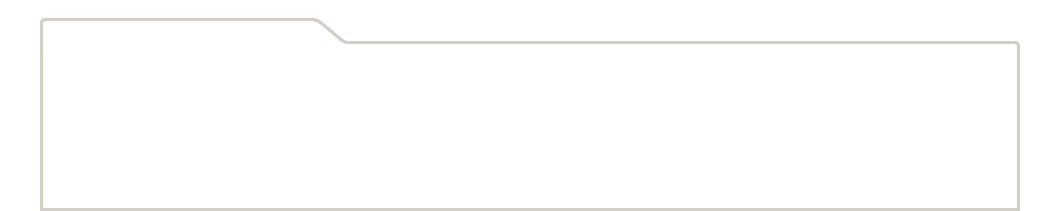
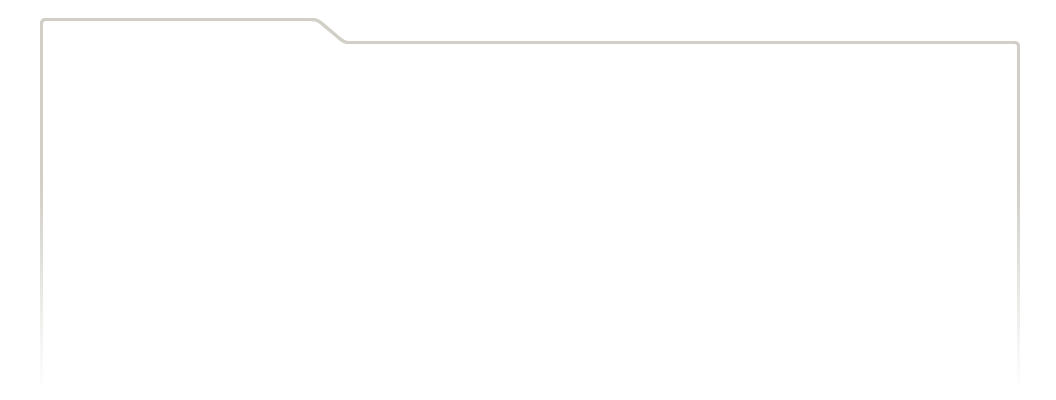
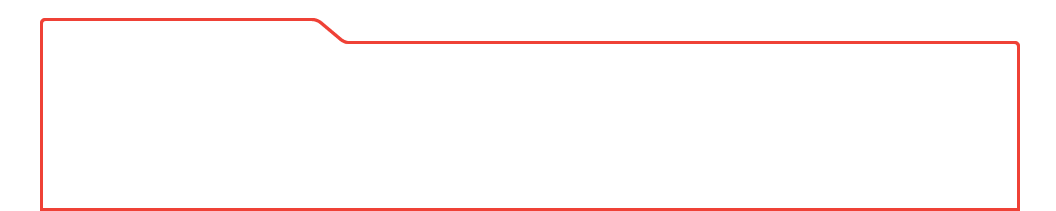
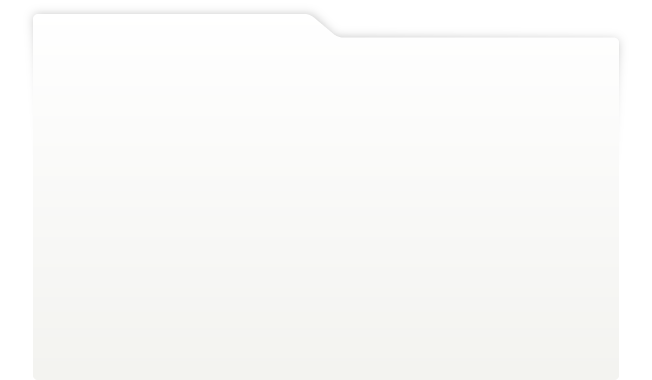
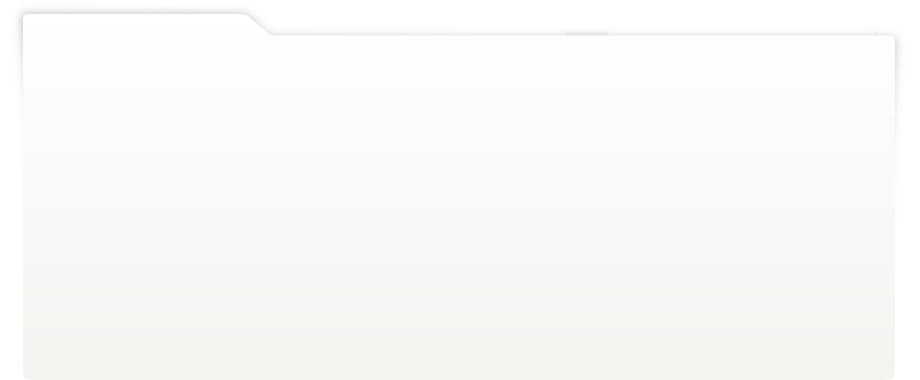
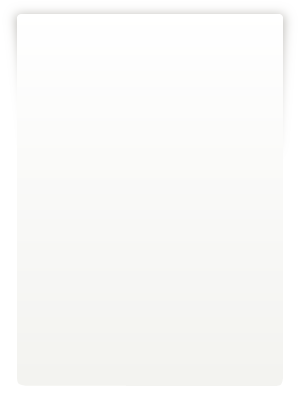
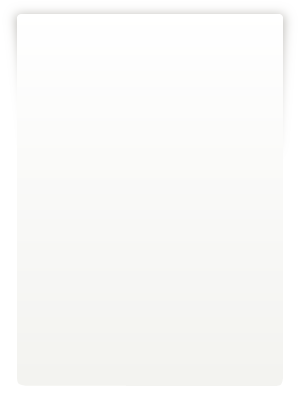
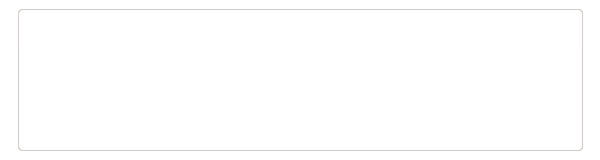
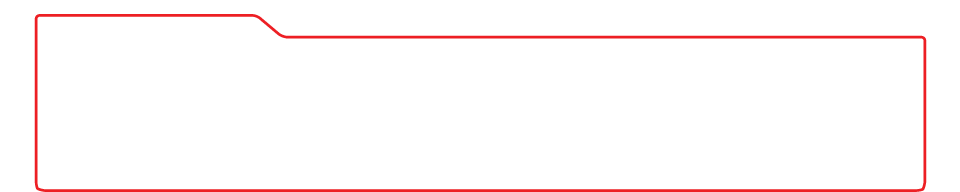
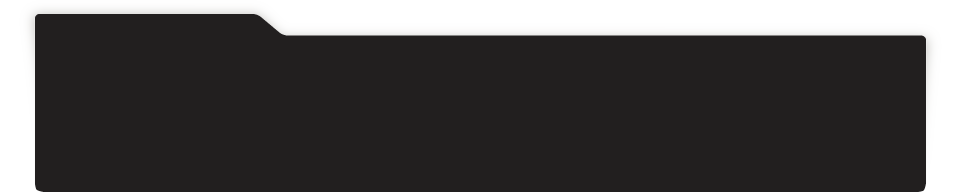
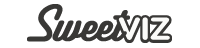
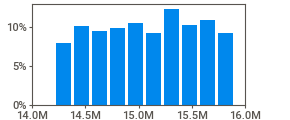
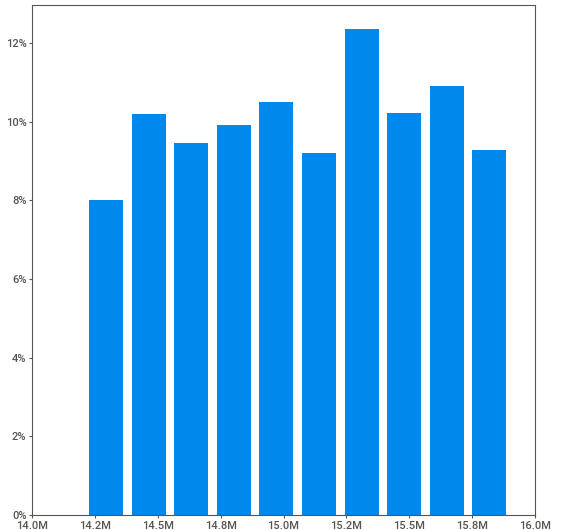
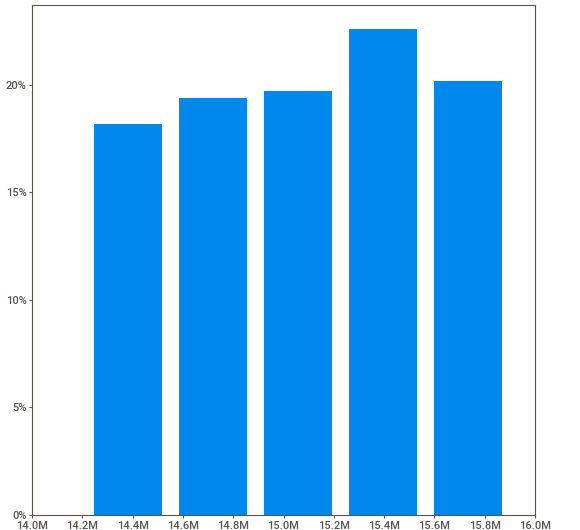
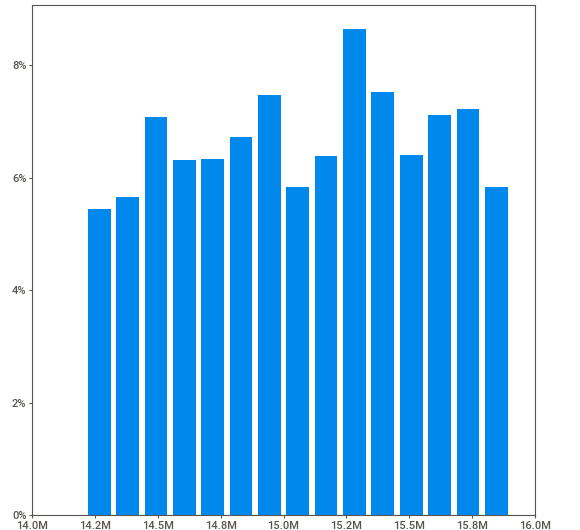
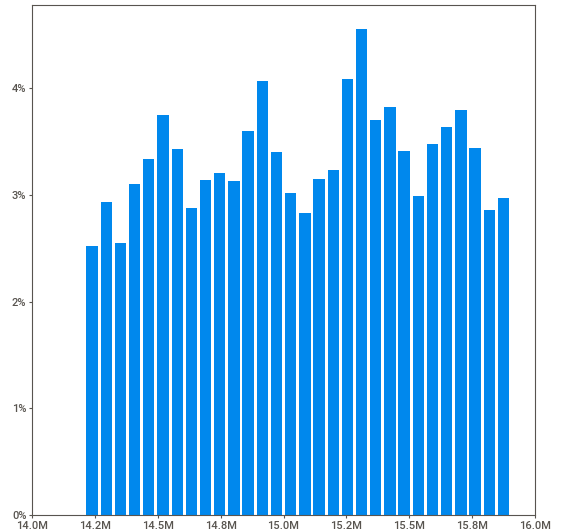
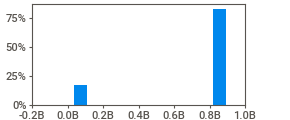
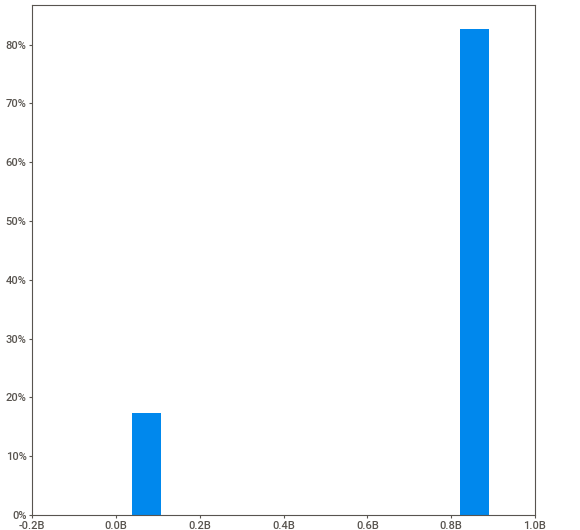
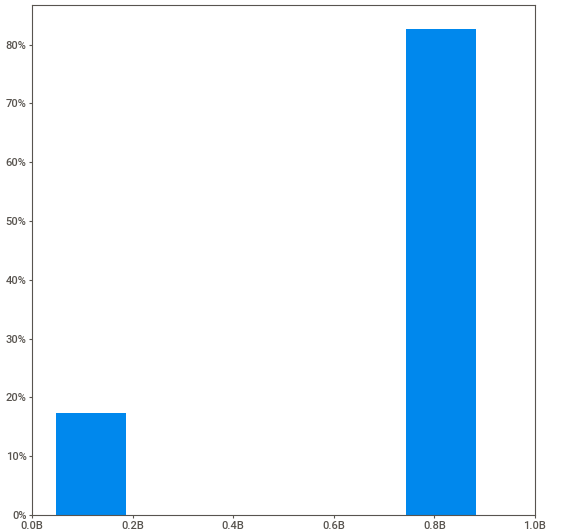
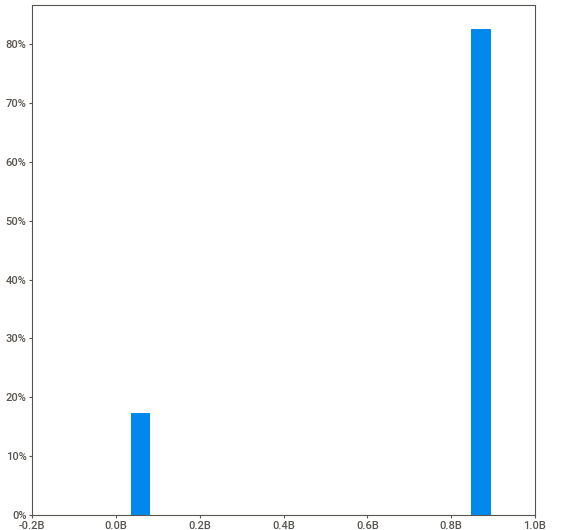
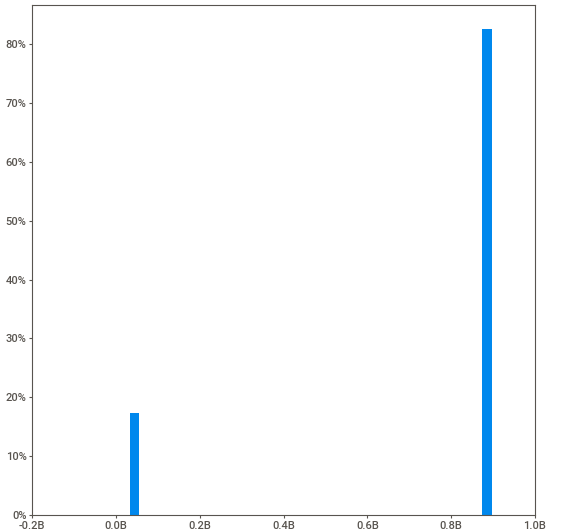
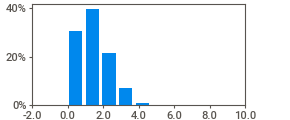
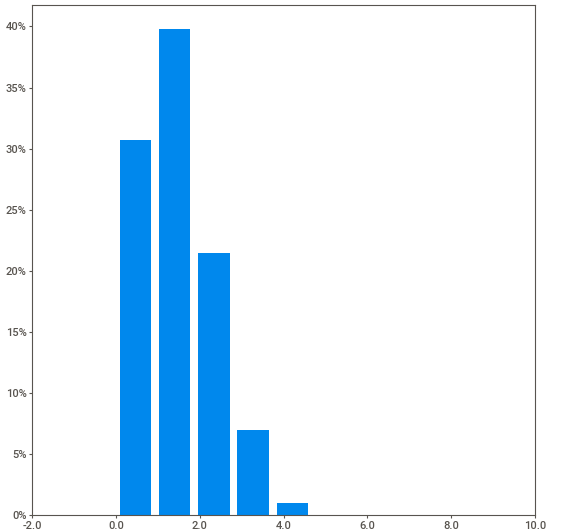
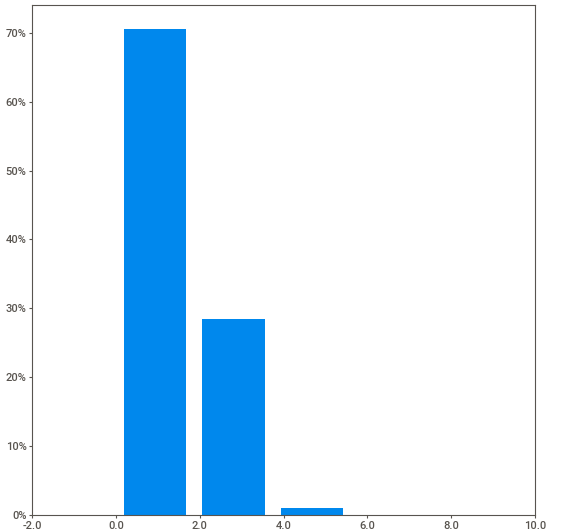
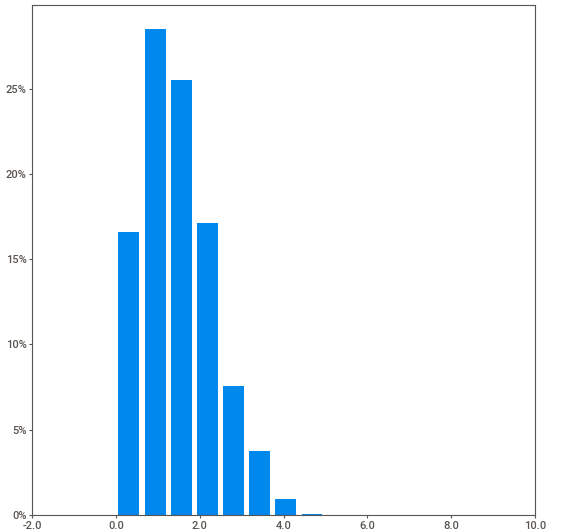
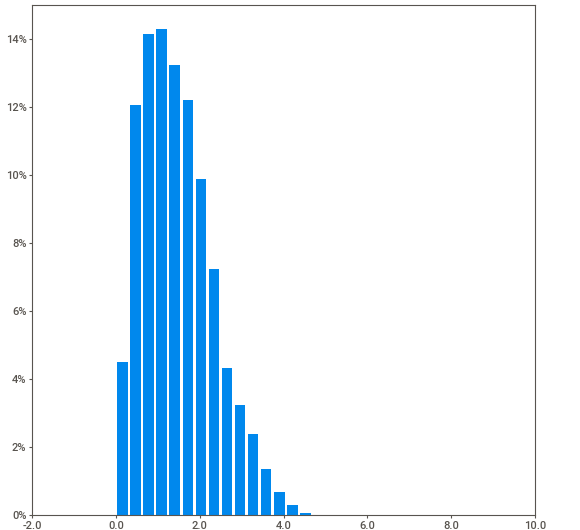
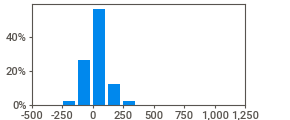
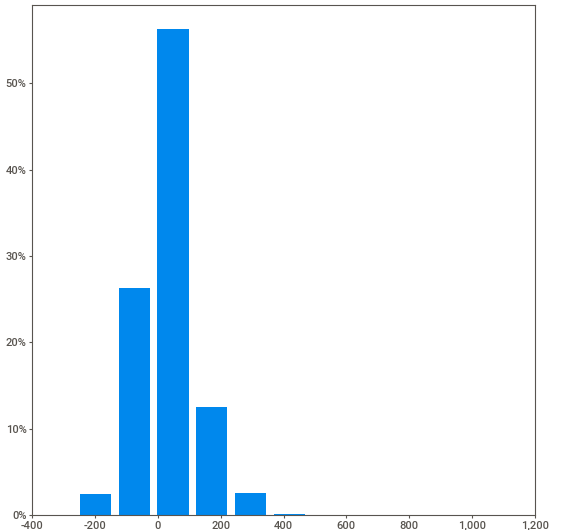
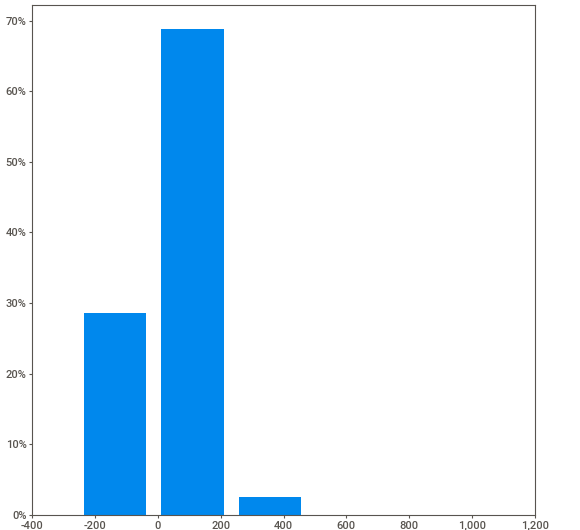
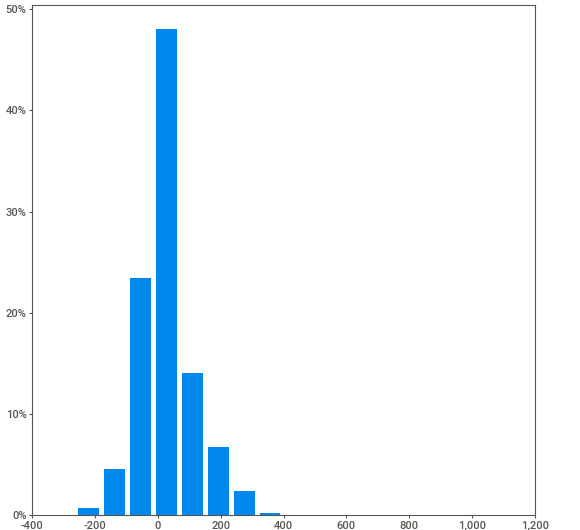
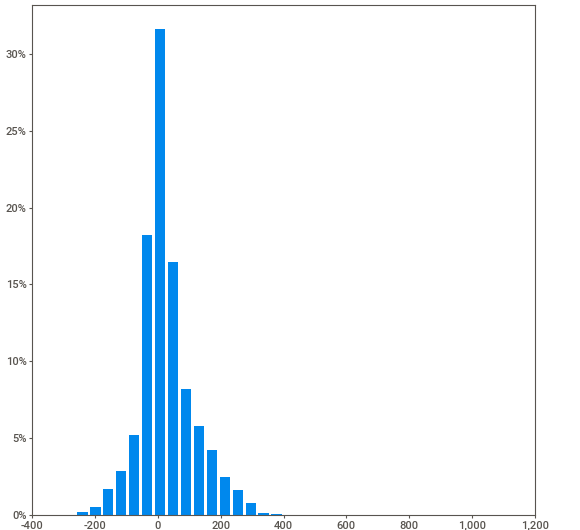
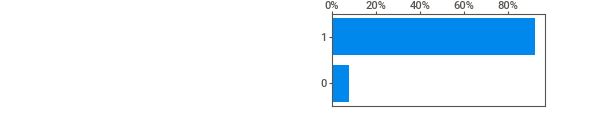
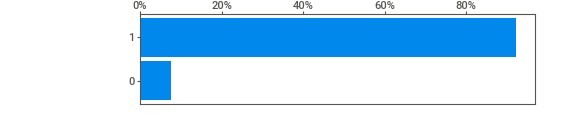
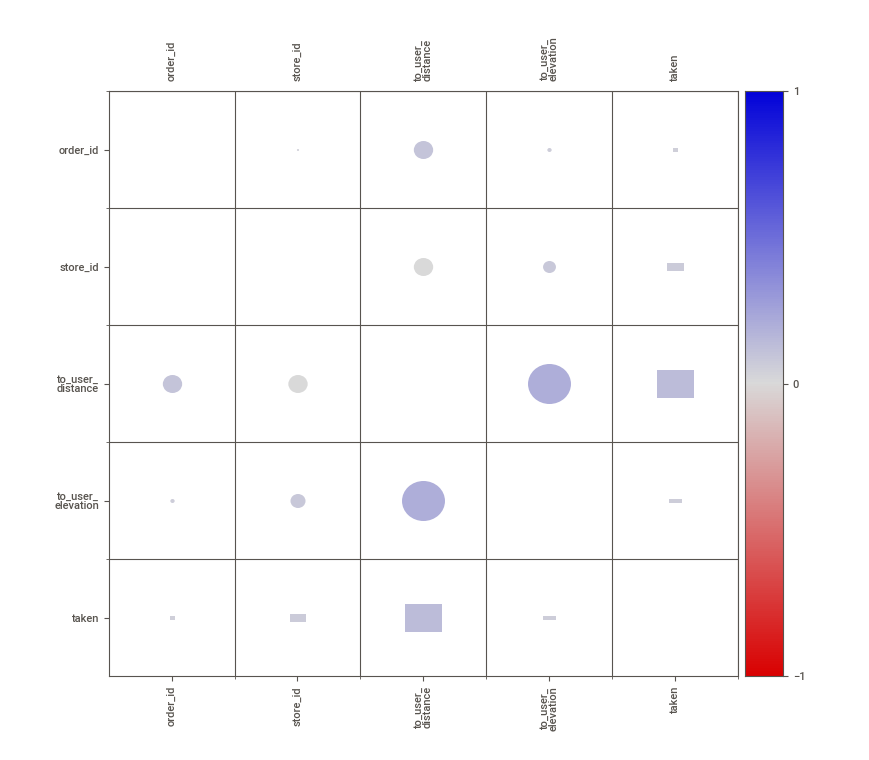
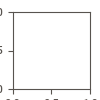

In [3]:
# Load the dataset
orders_df = pd.read_csv(database_path)
orders_df.columns = orders_df.columns.str.strip()

# Generate a profile report
report = sv.analyze(orders_df)
# Display the report in the notebook
report.show_notebook()

Summary of Data Inconsistencies after Cleaning:
Missing Values:
{'order_id': 0, 'store_id': 0, 'to_user_distance': 0, 'to_user_elevation': 0, 'total_earning': 0, 'created_at': 125549, 'taken': 0}
Invalid Entries:
{'order_id': 0, 'store_id': 0, 'to_user_distance': 0, 'to_user_elevation': 0, 'total_earning': 0, 'created_at': 0, 'taken': 0}
Empty Values:
{'order_id': 0, 'store_id': 0, 'to_user_distance': 0, 'to_user_elevation': 0, 'total_earning': 0, 'created_at': 0, 'taken': 0}
Non-numeric Values:
{'order_id': 125549, 'store_id': 125549, 'to_user_distance': 0, 'to_user_elevation': 0, 'total_earning': 0, 'created_at': 125549, 'taken': 125549}


                                             |          | [  0%]   00:00 -> (? left)

C:\Users\g00839270\AppData\Local\anaconda3\Lib\site-packages\sweetviz\series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()



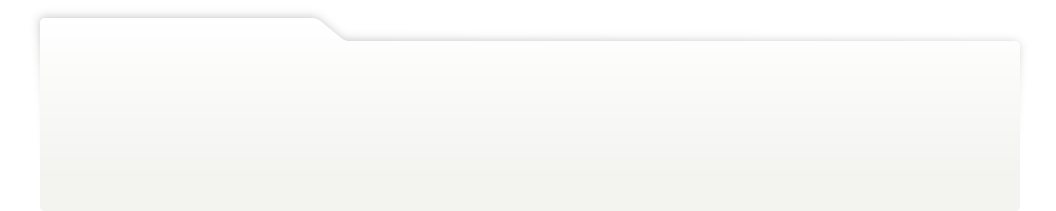
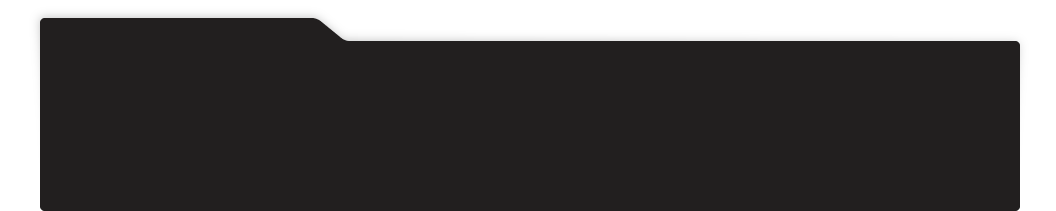
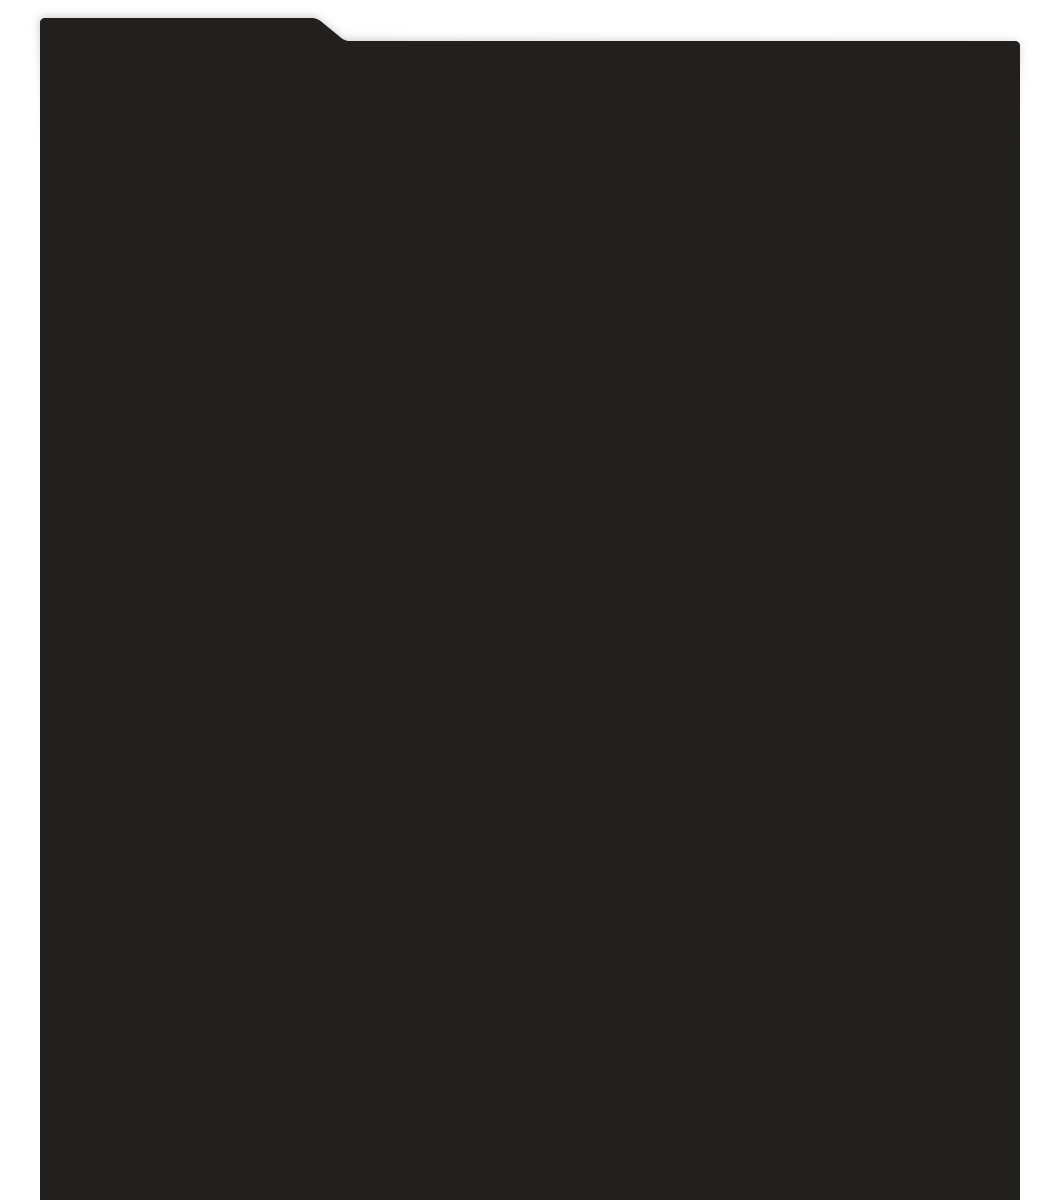
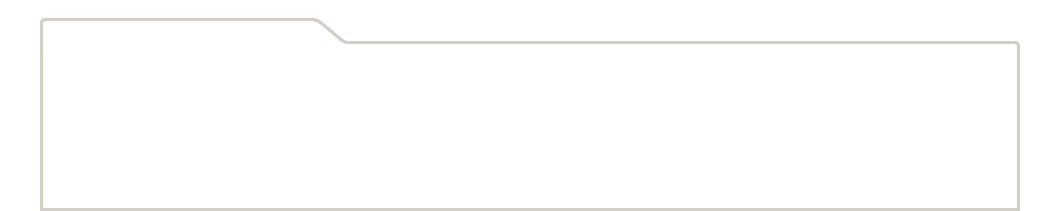
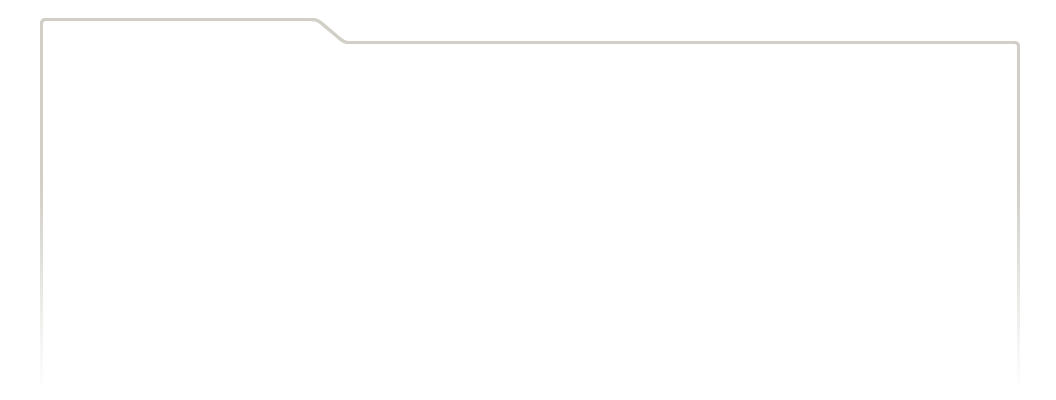
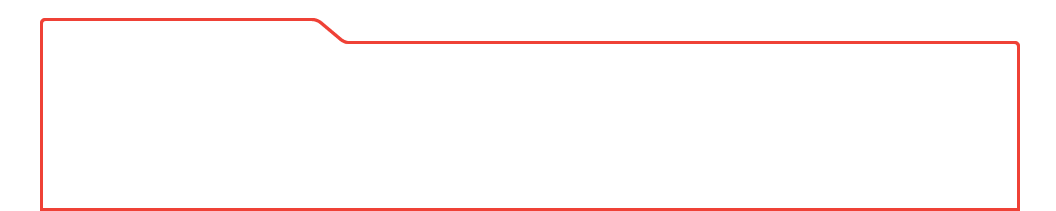
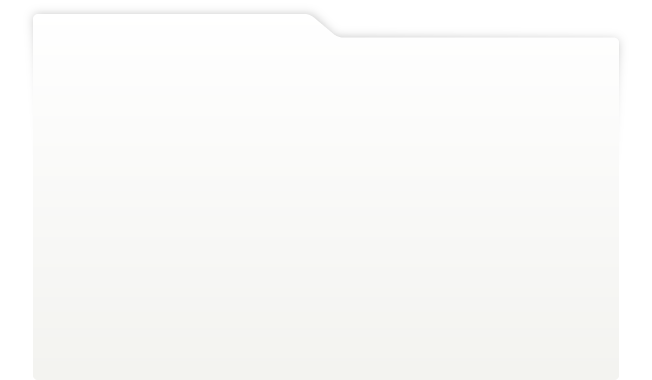
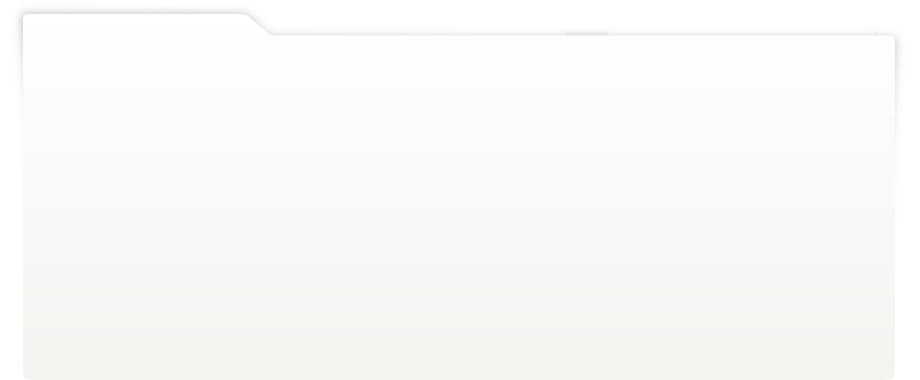
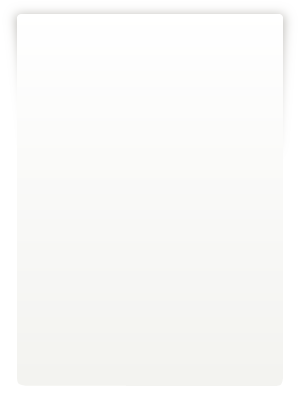
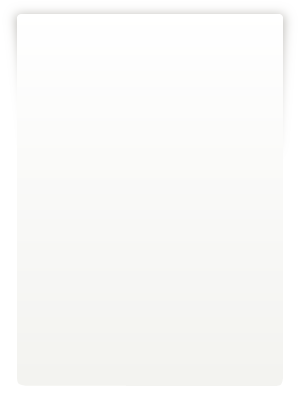
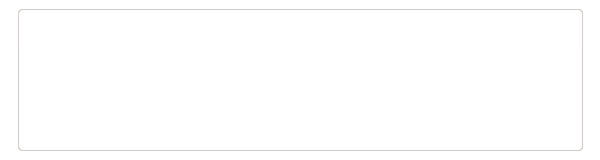
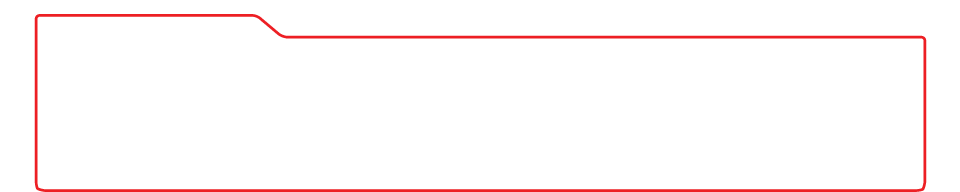
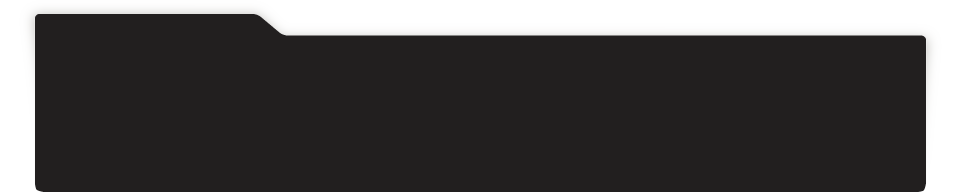
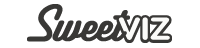
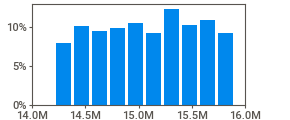
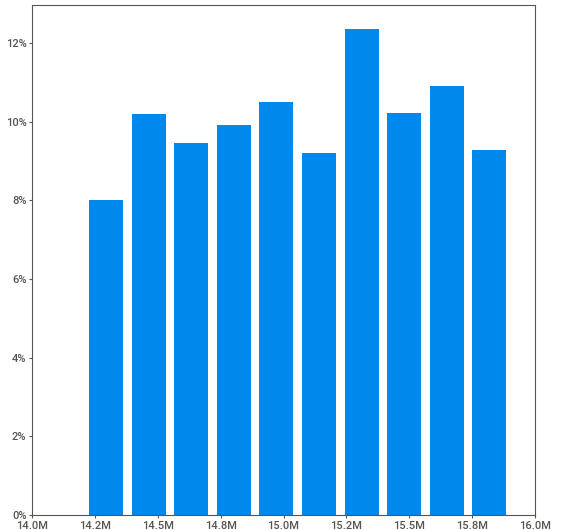
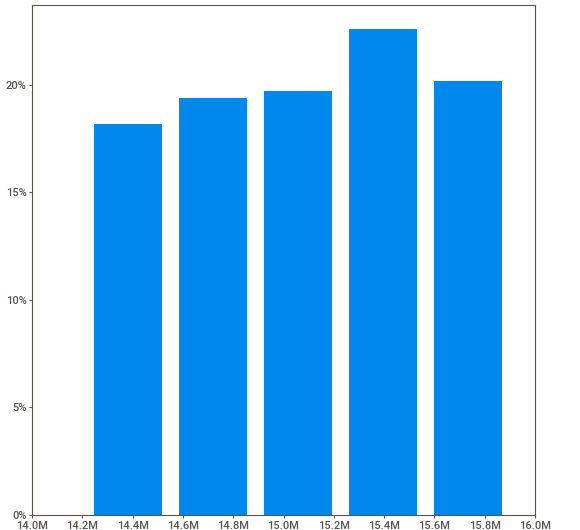
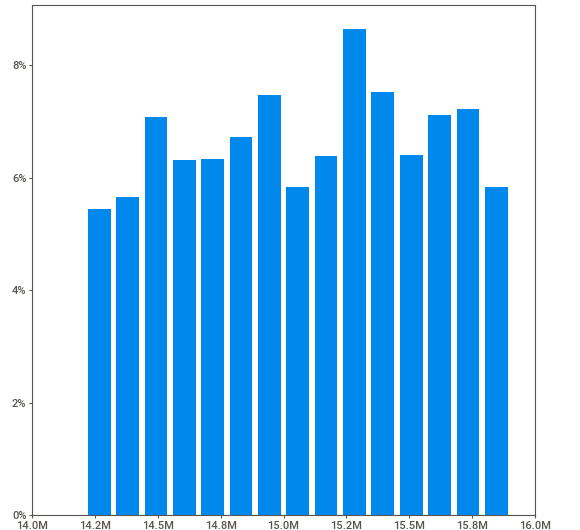
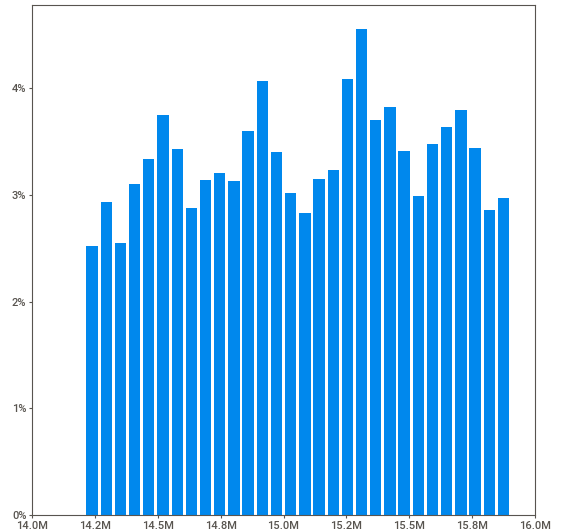
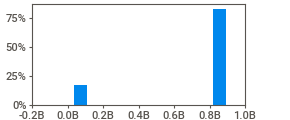
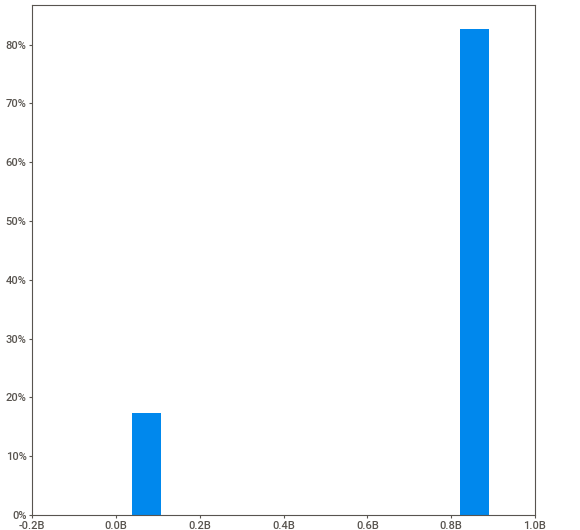
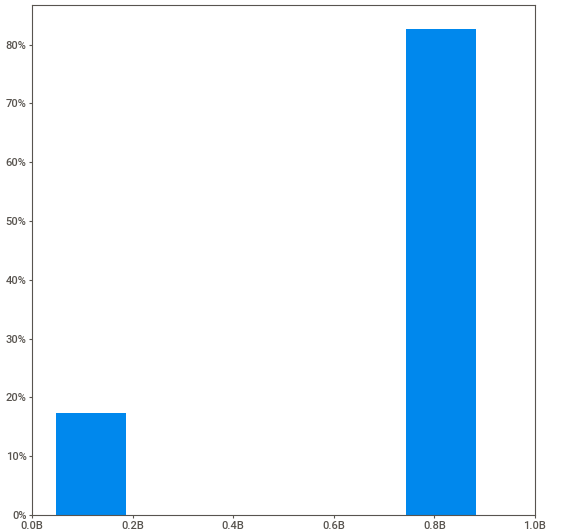
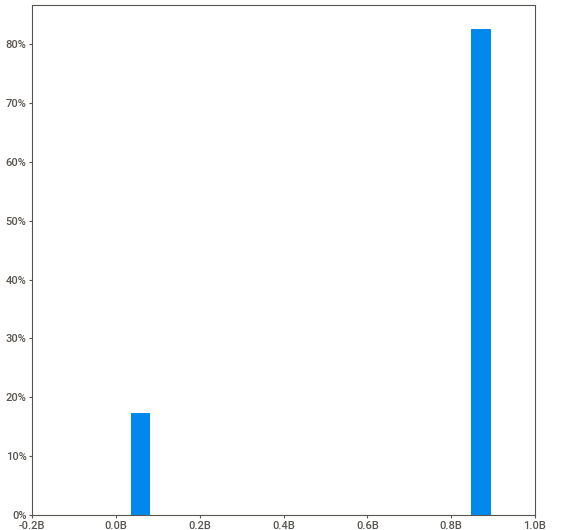
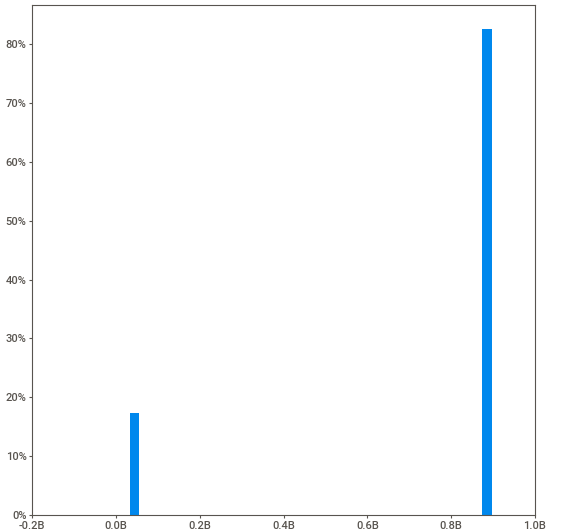
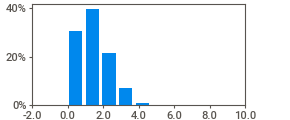
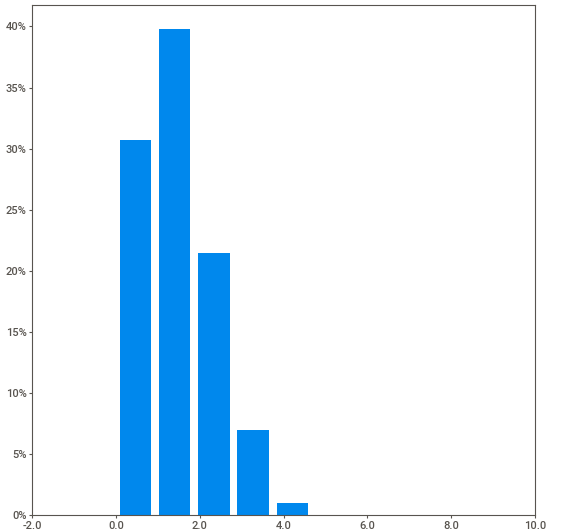
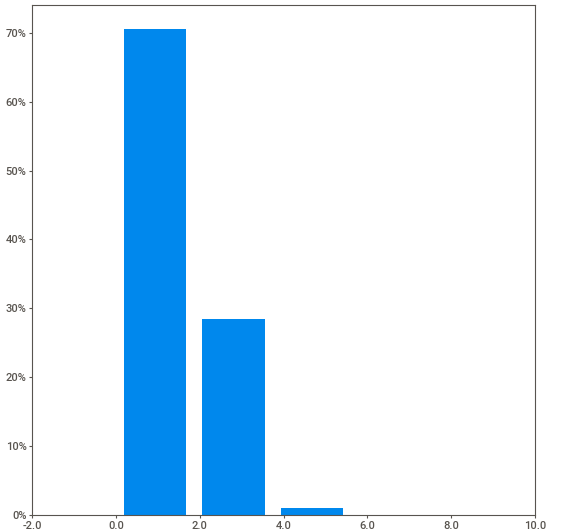
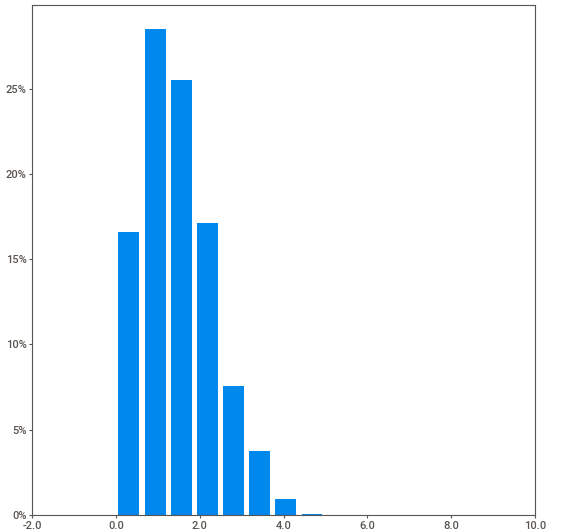
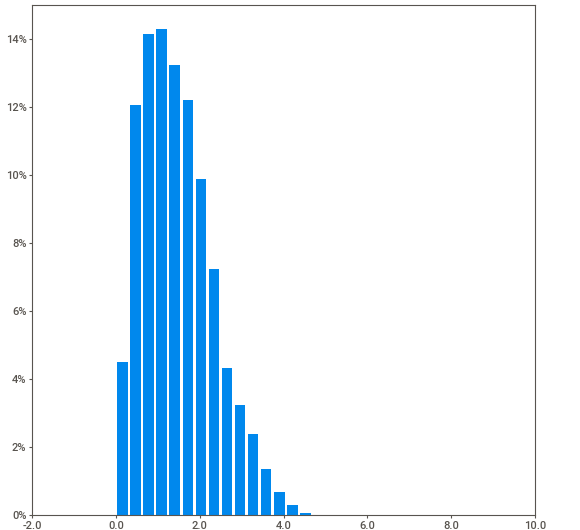
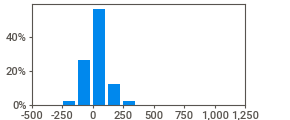
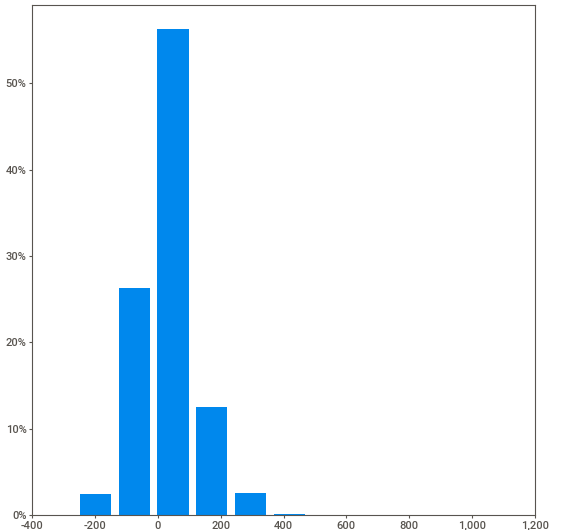
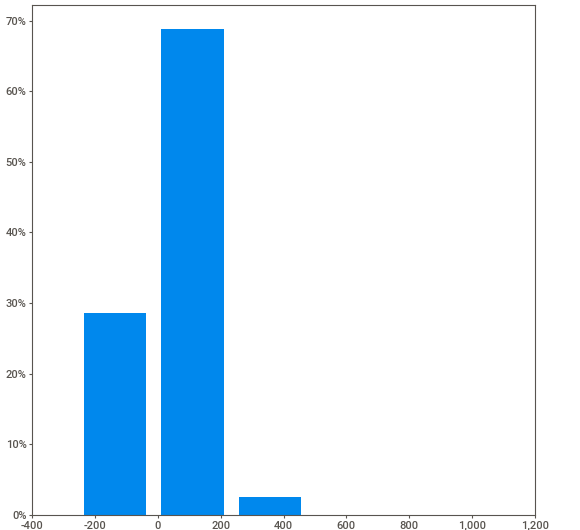
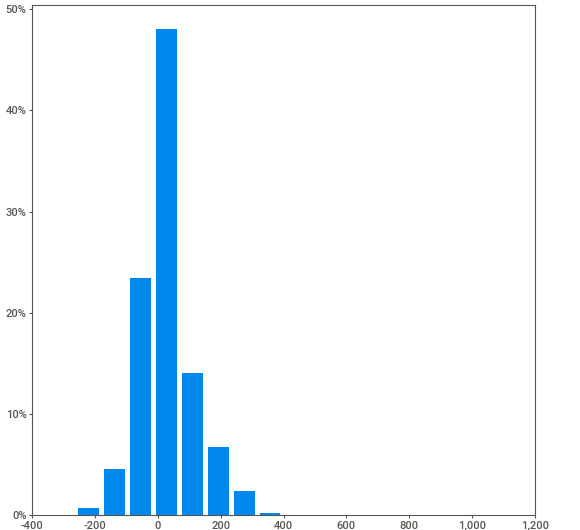
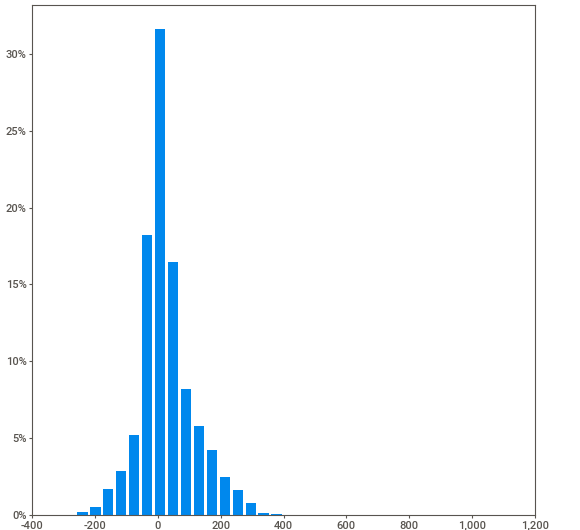
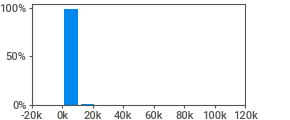
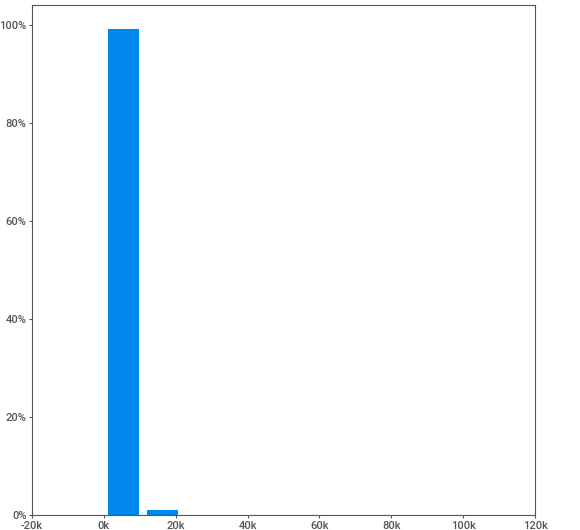
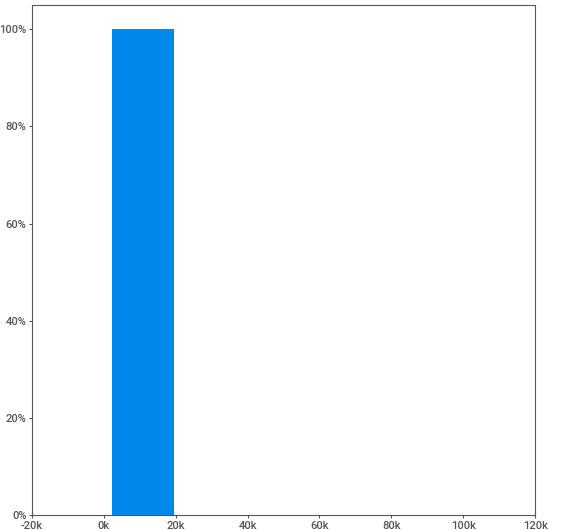
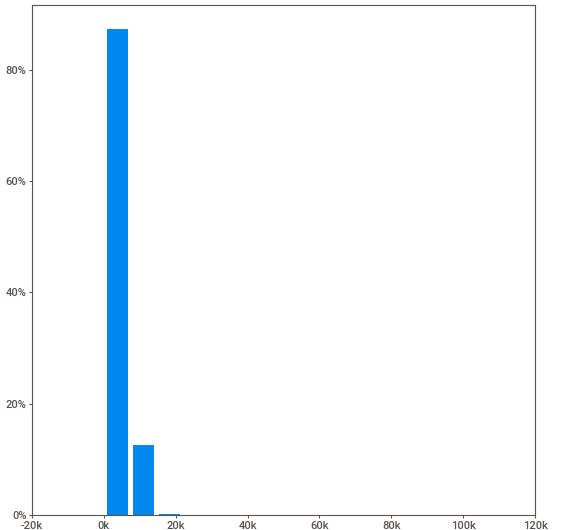
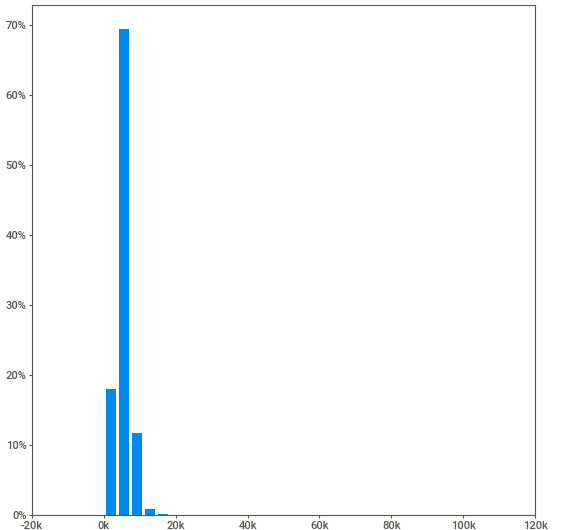
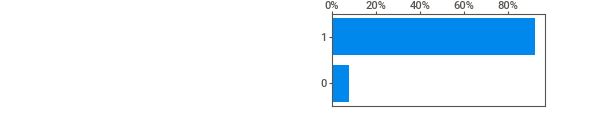
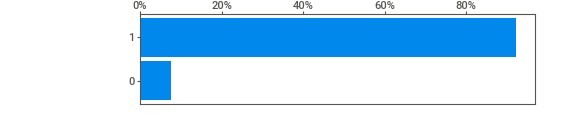
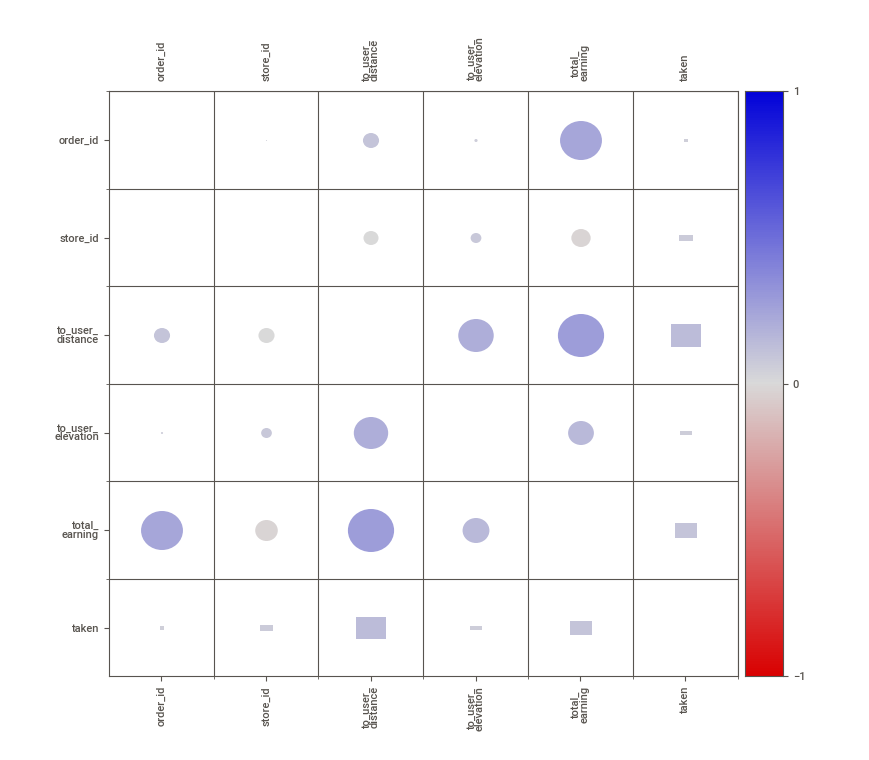
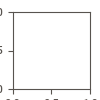

In [4]:
#Basic And Initial Set UP

# Define categorical columns
categorical_columns = ['order_id', 'store_id', 'taken']
# Perform Initial Data Cleaning for all columns except specified ones
orders_df = clean_all_columns(orders_df, categorical_columns)

# Convert relevant columns to numeric (if needed)
numeric_columns = [col for col in orders_df.columns if col not in categorical_columns]
orders_df[numeric_columns] = orders_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Recheck for inconsistencies after initial cleaning
inconsistencies_after_cleaning = check_inconsistencies(orders_df, categorical_columns)
print("Summary of Data Inconsistencies after Cleaning:")
print(f"Missing Values:\n{inconsistencies_after_cleaning['missing_values']}")
print(f"Invalid Entries:\n{inconsistencies_after_cleaning['invalid_entries']}")
print(f"Empty Values:\n{inconsistencies_after_cleaning['empty_values']}")
print(f"Non-numeric Values:\n{inconsistencies_after_cleaning['non_numeric_values']}")

# Generate a profile report
report = sv.analyze(orders_df)
# Display the report in the notebook
report.show_notebook()



Outliers identified using Z-score method:
(array([     0,      0,      1, ..., 125119, 125445, 125489], dtype=int64), array([0, 2, 0, ..., 2, 2, 2], dtype=int64))
Outliers identified using IQR method:
        to_user_distance  to_user_elevation  total_earning  created_at
0                   True              False           True       False
1                   True              False           True       False
2                   True              False           True       False
3                   True               True           True       False
4                   True              False           True       False
...                  ...                ...            ...         ...
125544             False              False          False       False
125545             False              False          False       False
125546             False              False          False       False
125547             False              False          False       False
125548            

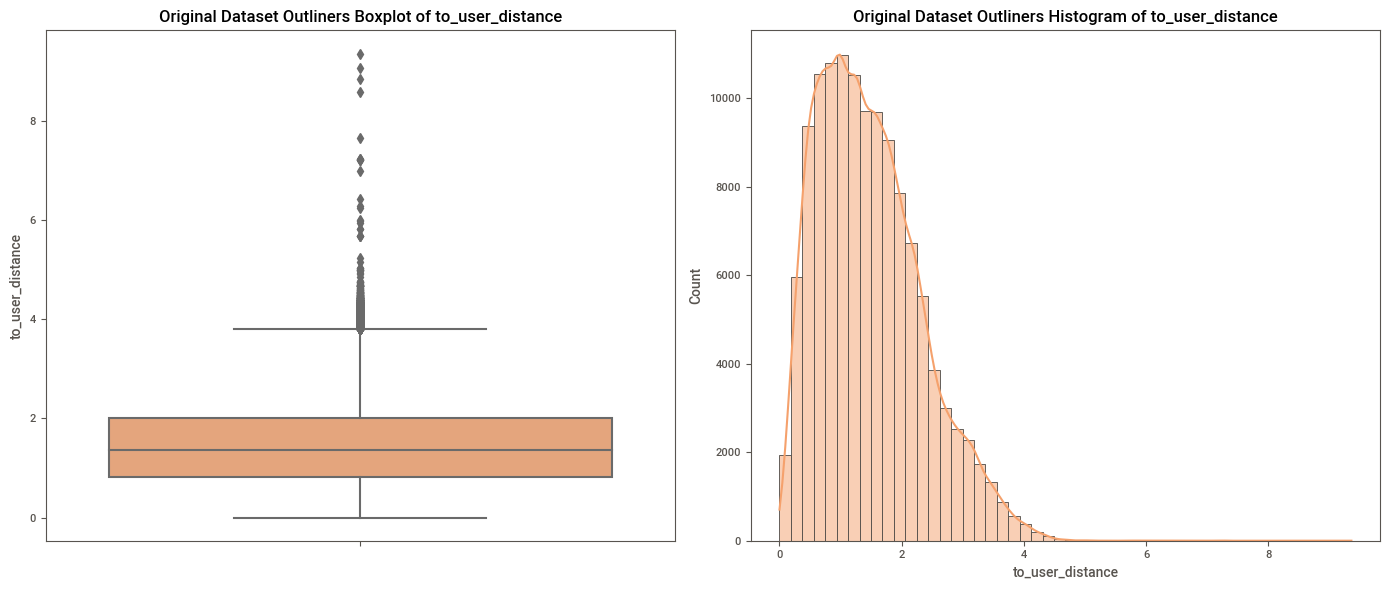

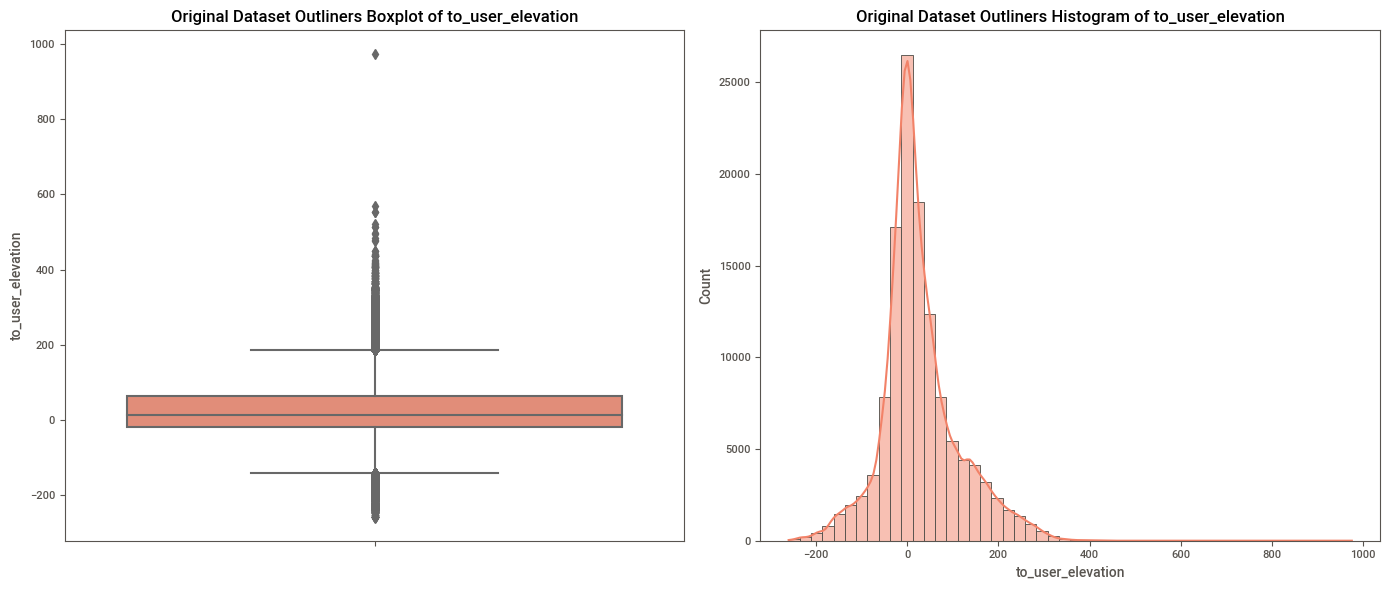

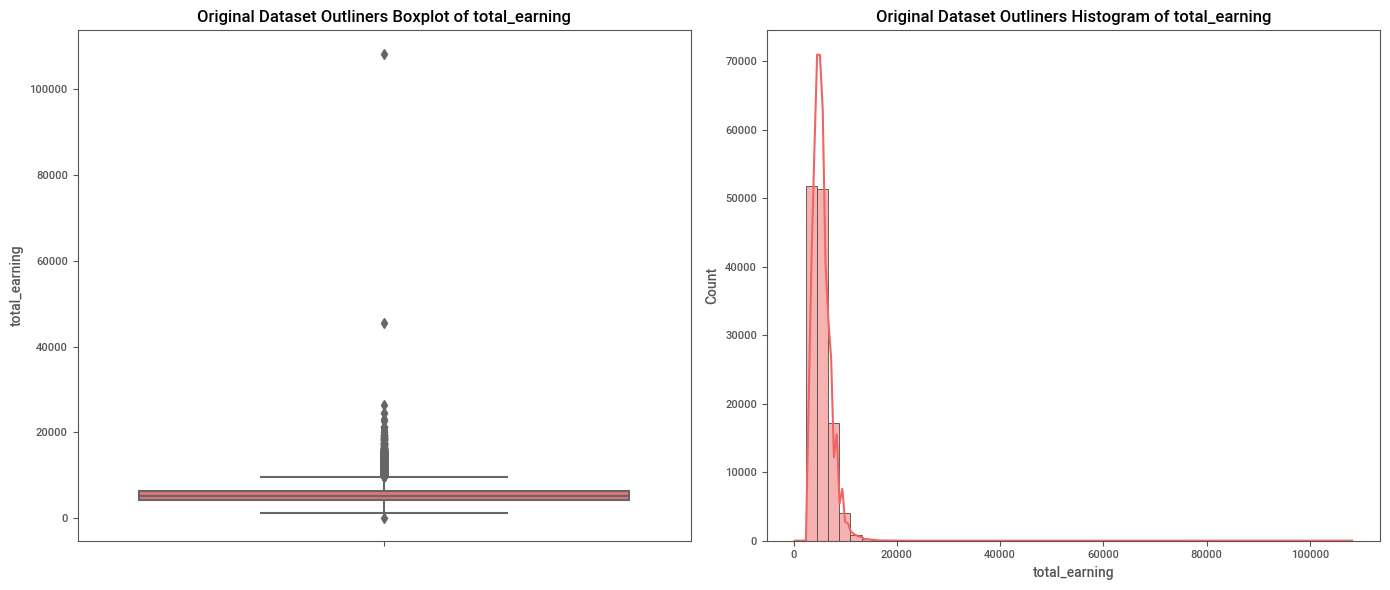

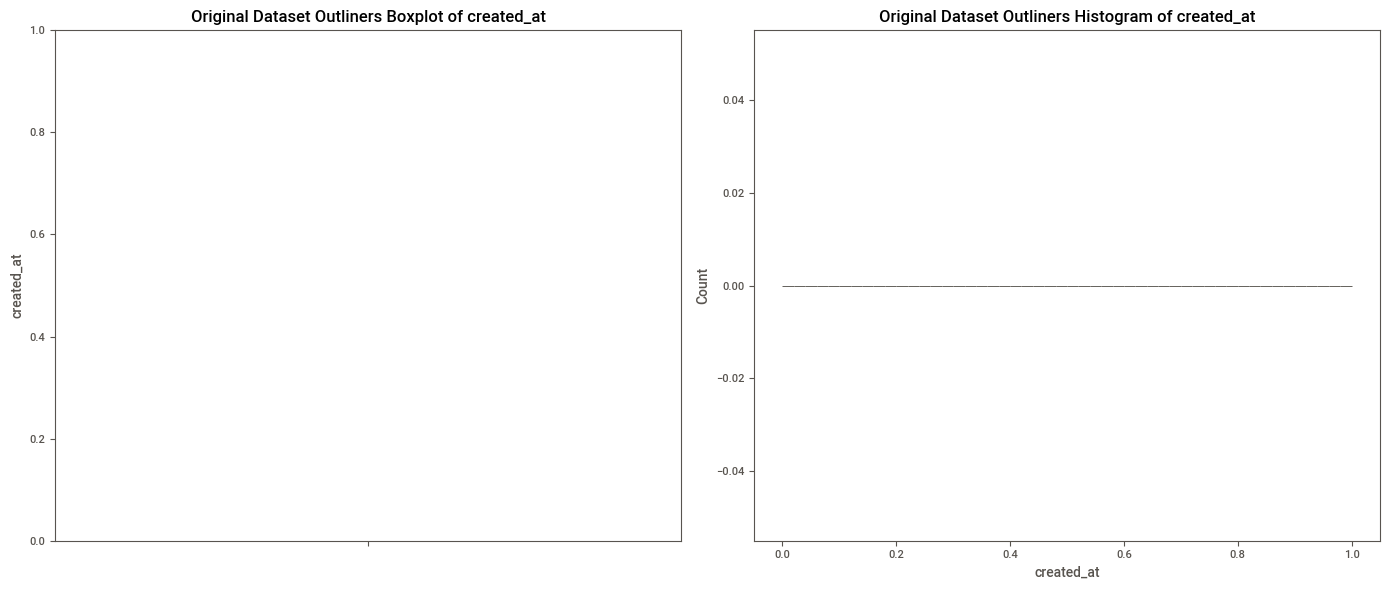

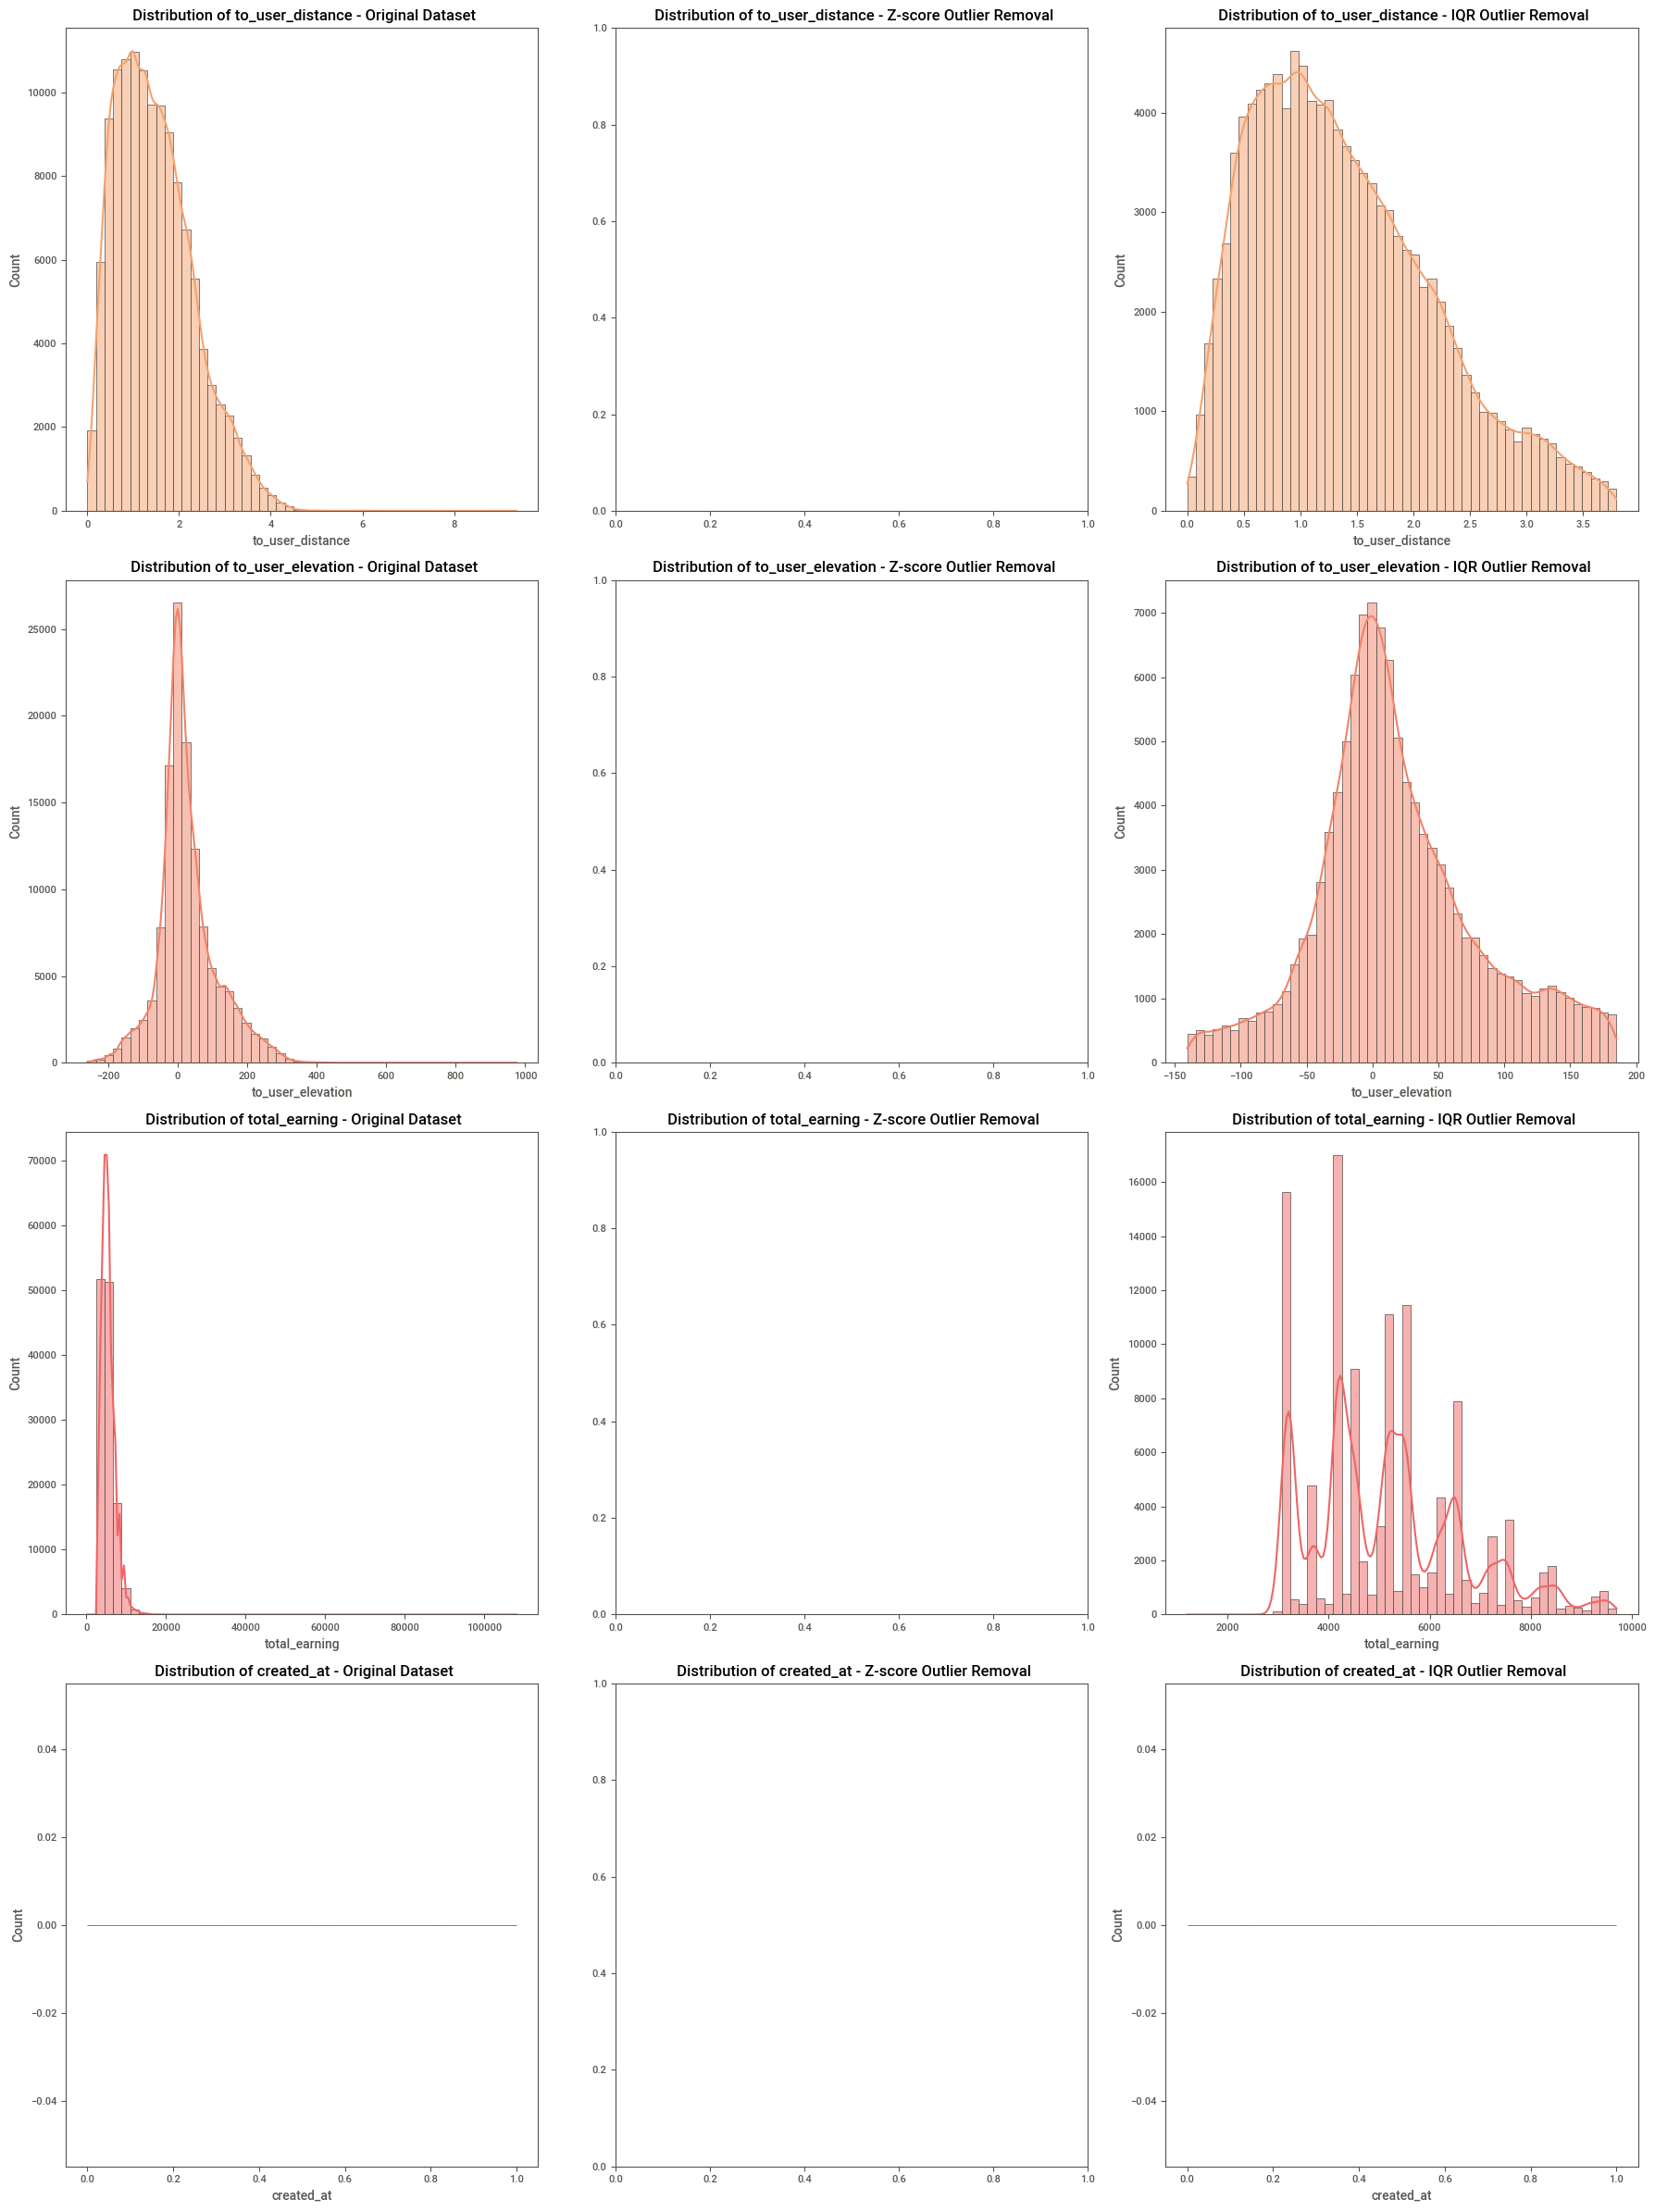

In [5]:
def plot_outliers(df, columns, colors):
    num_colors = len(colors)
    for i, column in enumerate(columns):
        plt.figure(figsize=(14, 6))
        
        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df, y=column, color=colors[i % num_colors])
        plt.title(f'Boxplot of {column}')
        
        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[column], bins=50, kde=True, color=colors[i % num_colors])
        plt.title(f'Histogram of {column}')
        
        plt.tight_layout()
        plt.show()

# Calculate Z-scores
z_scores = np.abs(stats.zscore(orders_df[numeric_columns]))
outliers = np.where(z_scores > 3)  # Typically, a Z-score above 3 is considered an outlier

# Print outliers
print(f"Outliers identified using Z-score method:\n{outliers}")

# Remove outliers using Z-score method
orders_df_cleaned_Z = orders_df[(z_scores < 3).all(axis=1)]

# Calculate IQR
Q1 = orders_df[numeric_columns].quantile(0.25)
Q3 = orders_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using IQR method
outliers_iqr = (orders_df[numeric_columns] < (Q1 - 1.5 * IQR)) | (orders_df[numeric_columns] > (Q3 + 1.5 * IQR))

# Print outliers using IQR method
print(f"Outliers identified using IQR method:\n{outliers_iqr}")

# Remove outliers using IQR method
orders_df_cleaned_iqr = orders_df[~((orders_df[numeric_columns] < (Q1 - 1.5 * IQR)) |(orders_df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Function to plot boxplots and histograms for outlier detection
def plot_outliers(df, columns, colors, title_prefix=''):
    num_colors = len(colors)
    for i, column in enumerate(columns):
        plt.figure(figsize=(14, 6))
        
        # Boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df, y=column, color=colors[i % num_colors])
        plt.title(f'{title_prefix} Boxplot of {column}')
        
        # Histogram
        plt.subplot(1, 2, 2)
        sns.histplot(df[column], bins=50, kde=True, color=colors[i % num_colors])
        plt.title(f'{title_prefix} Histogram of {column}')
        
        plt.tight_layout()
        plt.show()

# Plot outliers before removal
plot_outliers(orders_df, numeric_columns, rappi_colors, title_prefix='Original Dataset Outliners')

# Function to visualize distributions
def visualize_distributions(df, columns, title_prefix, colors):
    num_colors = len(colors)
    fig, axes = plt.subplots(len(columns), 3, figsize=(18, 6 * len(columns)))
    
    for i, column in enumerate(columns):
        sns.histplot(df[column], bins=50, kde=True, ax=axes[i, 0], color=colors[i % num_colors])
        axes[i, 0].set_title(f'{title_prefix} Distribution of {column} - Original Dataset')
        
        sns.histplot(orders_df_cleaned_Z[column], bins=50, kde=True, ax=axes[i, 1], color=colors[i % num_colors])
        axes[i, 1].set_title(f'{title_prefix} Distribution of {column} - Z-score Outlier Removal')
        
        sns.histplot(orders_df_cleaned_iqr[column], bins=50, kde=True, ax=axes[i, 2], color=colors[i % num_colors])
        axes[i, 2].set_title(f'{title_prefix} Distribution of {column} - IQR Outlier Removal')
    
    plt.tight_layout()
    plt.show()

# Visualize distributions
visualize_distributions(orders_df, numeric_columns, '', rappi_colors)

In [6]:
orders_df = pd.read_csv(database_path)
orders_df.columns = orders_df.columns.str.strip()
# Clean the 'total_earning' column
orders_df['total_earning'] = orders_df['total_earning'].astype(str)
orders_df['total_earning'] = orders_df['total_earning'].str.replace('[\$,]', '', regex=True).str.strip()
orders_df['total_earning'] = orders_df['total_earning'].replace('', np.nan).replace('-', np.nan)
# Convert 'total_earning' to numeric
orders_df['total_earning'] = pd.to_numeric(orders_df['total_earning'], errors='coerce')
# Convert 'created_at' to datetime format
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'], errors='coerce')

# Count the number of rows with missing values in 'total_earning' or 'created_at'
missing_total_earning = orders_df['total_earning'].isna().sum()
missing_created_at = orders_df['created_at'].isna().sum()
missing_both = orders_df[orders_df['total_earning'].isna() & orders_df['created_at'].isna()].shape[0]

print(f"Rows with missing 'total_earning': {missing_total_earning}")
print(f"Rows with missing 'created_at': {missing_created_at}")
print(f"Rows with missing both 'total_earning' and 'created_at': {missing_both}")

# Impute missing values
# For 'total_earning', we'll use the mean
mean_total_earning = orders_df['total_earning'].mean()
orders_df['total_earning'].fillna(mean_total_earning, inplace=True)

# For 'created_at', we'll use the mode (most frequent value)
mode_created_at = orders_df['created_at'].mode()[0]
orders_df['created_at'].fillna(mode_created_at, inplace=True)

# Ensure 'total_earning' is in numeric format
orders_df['total_earning'] = orders_df['total_earning'].astype(float)


Rows with missing 'total_earning': 1
Rows with missing 'created_at': 0
Rows with missing both 'total_earning' and 'created_at': 0


Hourly Data
   hour_of_day  taken  total_orders  acceptance_rate  rejection_rate
0            0    333           402         0.828358        0.171642
1            1    195           268         0.727612        0.272388
2            2     98           139         0.705036        0.294964
3            3     73           114         0.640351        0.359649
4            4     43            69         0.623188        0.376812
Daily Data
   day_of_week  taken  total_orders  acceptance_rate  rejection_rate
0            0  11774         12887         0.913634        0.086366
1            1  16774         18098         0.926843        0.073157
2            2  14970         16060         0.932130        0.067870
3            3  12851         14103         0.911225        0.088775
4            4  16624         18254         0.910705        0.089295
Distance Data
  distance_range  taken  total_orders  acceptance_rate  rejection_rate
0          <1 km  40321         42401         0.950945        0.

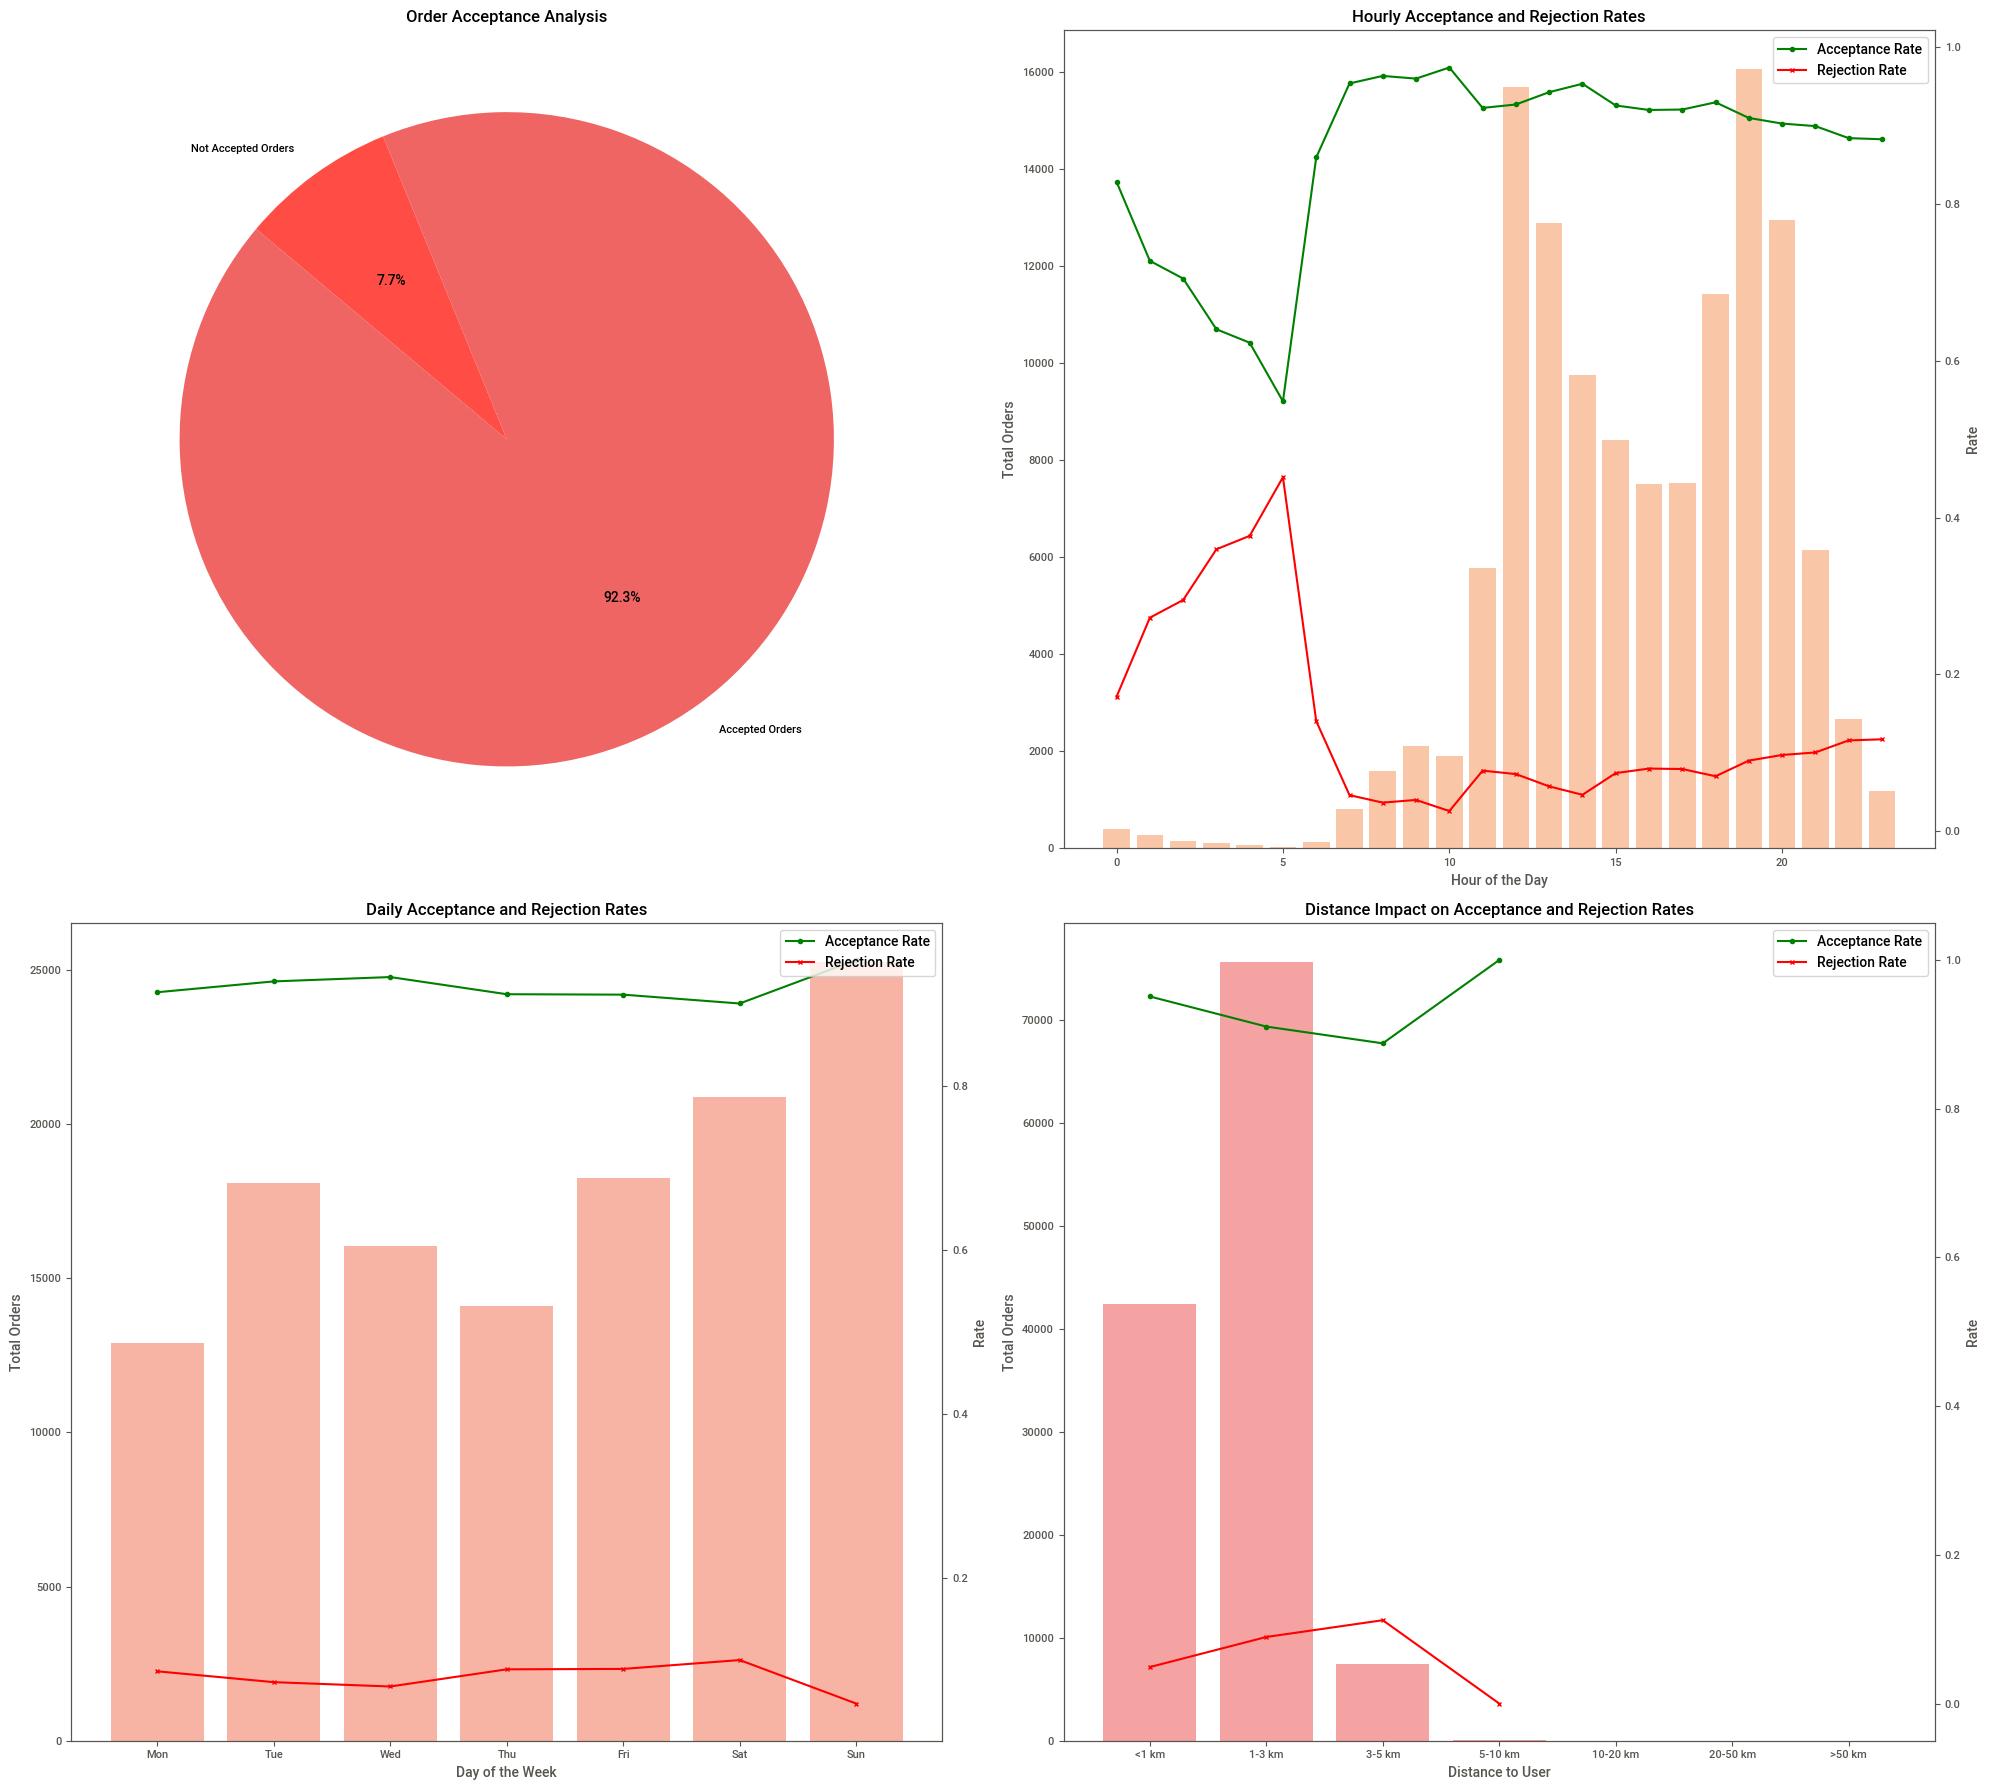

In [7]:
orders_df = pd.read_csv(database_path)
orders_df.columns = orders_df.columns.str.strip()
orders_df['total_earning'] = orders_df['total_earning'].str.replace('[\$,]', '', regex=True).str.strip() # Clean the 'total_earning' column
orders_df['total_earning'] = orders_df['total_earning'].replace('', np.nan).replace('-', np.nan) # Replace invalid entries with NaN
orders_df['total_earning'] = pd.to_numeric(orders_df['total_earning'], errors='coerce') # Convert 'total_earning' to numeric
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'], errors='coerce') # Convert 'created_at' to datetime format
orders_df = orders_df.dropna(subset=['total_earning', 'created_at']) # Drop rows with missing values in 'total_earning' or 'created_at'

# Drop rows with any remaining missing values
orders_df = orders_df.dropna()


# Extract additional temporal features
orders_df['day_of_week'] = orders_df['created_at'].dt.dayofweek
orders_df['hour_of_day'] = orders_df['created_at'].dt.hour


# Function to plot grouped graphs
def plot_grouped_graphs():
    fig, axes = plt.subplots(2, 2, figsize=(20, 18))
    
    # Order Acceptance Analysis
    total_orders = len(orders_df)
    not_accepted_orders = orders_df[orders_df['taken'] == 0].shape[0]
    accepted_orders = total_orders - not_accepted_orders
    
    if total_orders == 0:
        print("No orders available for analysis.")
        return

    ax = axes[0, 0]
    labels = ['Accepted Orders', 'Not Accepted Orders']
    sizes = [accepted_orders, not_accepted_orders]
    colors = [rappi_colors[2], rappi_colors[7]]
    
    if any(size == 0 for size in sizes):
        print("Some categories have zero orders. Skipping pie chart.")
    else:
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        ax.set_title('Order Acceptance Analysis')
    
    # Temporal Patterns: Hourly Acceptance Rates
    hourly_data = orders_df.groupby('hour_of_day').agg({
        'taken': ['sum', 'count']
    }).reset_index()
    hourly_data.columns = ['hour_of_day', 'taken', 'total_orders']
    hourly_data['acceptance_rate'] = hourly_data['taken'] / hourly_data['total_orders']
    hourly_data['rejection_rate'] = 1 - hourly_data['acceptance_rate']
    
    print("Hourly Data")
    print(hourly_data.head())  # Debug statement
    
    ax = axes[0, 1]
    if not hourly_data.empty:
        ax.bar(hourly_data['hour_of_day'], hourly_data['total_orders'], color=rappi_colors[0], alpha=0.6)
        ax2 = ax.twinx()
        ax2.plot(hourly_data['hour_of_day'], hourly_data['acceptance_rate'], color='green', marker='o', label='Acceptance Rate')
        ax2.plot(hourly_data['hour_of_day'], hourly_data['rejection_rate'], color='red', marker='x', label='Rejection Rate')
        ax.set_xlabel('Hour of the Day')
        ax.set_ylabel('Total Orders')
        ax2.set_ylabel('Rate')
        ax.set_title('Hourly Acceptance and Rejection Rates')
        ax2.legend(loc='upper right')
    else:
        print("No hourly data available for plotting.")
    
    # Temporal Patterns: Daily Acceptance Rates
    daily_data = orders_df.groupby('day_of_week').agg({
        'taken': ['sum', 'count']
    }).reset_index()
    daily_data.columns = ['day_of_week', 'taken', 'total_orders']
    daily_data['acceptance_rate'] = daily_data['taken'] / daily_data['total_orders']
    daily_data['rejection_rate'] = 1 - daily_data['acceptance_rate']
    
    print("Daily Data")
    print(daily_data.head())  # Debug statement
    
    ax = axes[1, 0]
    if not daily_data.empty:
        ax.bar(daily_data['day_of_week'], daily_data['total_orders'], color=rappi_colors[1], alpha=0.6)
        ax2 = ax.twinx()
        ax2.plot(daily_data['day_of_week'], daily_data['acceptance_rate'], color='green', marker='o', label='Acceptance Rate')
        ax2.plot(daily_data['day_of_week'], daily_data['rejection_rate'], color='red', marker='x', label='Rejection Rate')
        ax.set_xlabel('Day of the Week')
        ax.set_ylabel('Total Orders')
        ax2.set_ylabel('Rate')
        ax.set_title('Daily Acceptance and Rejection Rates')
        ax.set_xticks(range(7))
        ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        ax2.legend(loc='upper right')
    else:
        print("No daily data available for plotting.")
    
    # Distance and Elevation Impact
    bins_distance = [0, 1, 3, 5, 10, 20, 50, np.inf]
    labels_distance = ['<1 km', '1-3 km', '3-5 km', '5-10 km', '10-20 km', '20-50 km', '>50 km']
    orders_df['distance_range'] = pd.cut(orders_df['to_user_distance'], bins=bins_distance, labels=labels_distance)
    distance_data = orders_df.groupby('distance_range').agg({
        'taken': ['sum', 'count']
    }).reset_index()
    distance_data.columns = ['distance_range', 'taken', 'total_orders']
    distance_data['acceptance_rate'] = distance_data['taken'] / distance_data['total_orders']
    distance_data['rejection_rate'] = 1 - distance_data['acceptance_rate']
    
    print("Distance Data")
    print(distance_data.head())  # Debug statement
    
    ax = axes[1, 1]
    if not distance_data.empty:
        ax.bar(distance_data['distance_range'], distance_data['total_orders'], color=rappi_colors[2], alpha=0.6)
        ax2 = ax.twinx()
        ax2.plot(distance_data['distance_range'], distance_data['acceptance_rate'], color='green', marker='o', label='Acceptance Rate')
        ax2.plot(distance_data['distance_range'], distance_data['rejection_rate'], color='red', marker='x', label='Rejection Rate')
        ax.set_xlabel('Distance to User')
        ax.set_ylabel('Total Orders')
        ax2.set_ylabel('Rate')
        ax.set_title('Distance Impact on Acceptance and Rejection Rates')
        ax2.legend(loc='upper right')
    else:
        print("No distance data available for plotting.")
    
    plt.tight_layout()
    plt.show()

plot_grouped_graphs()


## Pairwise Plots

**Distributions:**

**to_user_distance:** Mostly short distances.

**to_user_elevation:** Wide range of elevations with a peak around zero.

**total_earning:** Mostly lower earnings with some high outliers.

**hour:** Peaks at meal times and late evening.

**week:** Shows data spread over several weeks.

**Relationships:**

**Weak correlations:** Most variables do not show strong pairwise relationships.

**Distance and Earnings:** Slight positive correlation; higher distances can lead to higher earnings.

**Elevation and Earnings:** Slight correlation; varied elevations can slightly influence earnings.

**Decision to take an order:** The taken variable (0 or 1) is evenly distributed across most variables, suggesting other factors might be more influential in deciding whether an order is taken or not.

In [ ]:
# Pairwise plots to visualize relationships between features and the target variable
orders_df_subset = orders_df.drop(columns=['order_id', 'store_id', 'created_at'])

# Generate pairwise plots to visualize relationships between features and the target variable
sns.pairplot(orders_df_subset, hue='taken', palette=rappi_colors[:2])
plt.suptitle('Pairwise Plots of Features', y=1.02)
plt.show()

## **First Analysis and Insights**

He are some insights from this first EDA:

**Overall Order Acceptance Rate**
Insight: 92.3% of orders are accepted, while 7.7% are not accepted.

**Temporal Patterns**
Hourly Acceptance Rates
Insight: The highest number of orders are placed around noon, with varying acceptance rates throughout the day.

**Daily Acceptance Rates**
Insight: The highest number of orders are placed on weekends, but acceptance rates remain relatively constant.

**Distance Impact**
Insight: Orders within 1-3 km have the highest acceptance rates, while orders beyond 10 km see a significant drop in acceptance.



In [25]:
# @title Setup Dataset
orders_df = pd.read_csv(database_path)
orders_df.columns = orders_df.columns.str.strip()
# Perform Initial Data Cleaning
orders_df['total_earning'] = orders_df['total_earning'].astype(str)
orders_df = orders_df[~orders_df['total_earning'].str.contains(' - ')]
orders_df = orders_df[orders_df['total_earning'].str.strip() != '']
orders_df['total_earning'] = orders_df['total_earning'].str.replace('[\$,]', '', regex=True).str.strip()
orders_df = orders_df[orders_df['total_earning'].str.replace('.', '', regex=False).str.isnumeric()]
orders_df['total_earning'] = orders_df['total_earning'].astype(float)
orders_df.fillna(orders_df.mean(numeric_only=True), inplace=True)
# Ensure created_at is in datetime format
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'])


# Calculate the number of orders per day
orders_per_day = orders_df.groupby(orders_df['created_at'].dt.date).size().reset_index(name='orders_per_day')
orders_per_day.rename(columns={'created_at': 'order_date'}, inplace=True)

# Merge the orders_per_day back into the original dataframe
orders_df['order_date'] = orders_df['created_at'].dt.date
orders_df = orders_df.merge(orders_per_day, left_on='order_date', right_on='order_date', how='left')
orders_df.rename(columns={'orders_per_day': 'avg_orders_per_day'}, inplace=True)
orders_df.drop(columns=['order_date'], inplace=True)

# Proceed with feature engineering
orders_df['order_hour'] = orders_df['created_at'].dt.hour
orders_df['order_dayofweek'] = orders_df['created_at'].dt.dayofweek
orders_df['order_weekend'] = orders_df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
orders_df['order_month'] = orders_df['created_at'].dt.month
orders_df['order_day'] = orders_df['created_at'].dt.day
orders_df['order_hour_bin'] = pd.cut(orders_df['order_hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Add rush hour indicator
orders_df['rush_hour'] = orders_df['order_hour'].apply(lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0)

# Add day part indicator
day_parts = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']
orders_df['day_part'] = pd.cut(orders_df['order_hour'], bins=[-1, 6, 9, 12, 18, 24], labels=day_parts)

# Distance and elevation features
orders_df['earning_per_km'] = orders_df['total_earning'] / (orders_df['to_user_distance'] + 1e-5)
orders_df['distance_elevation_interaction'] = orders_df['to_user_distance'] * orders_df['to_user_elevation']
orders_df['relative_elevation'] = orders_df['to_user_elevation'].apply(lambda x: 1 if x > 0 else 0)
orders_df['elevation_change_rate'] = orders_df['to_user_elevation'] / (orders_df['to_user_distance'] + 1e-5)

# Add distance to elevation ratio
orders_df['distance_to_elevation_ratio'] = orders_df['to_user_distance'] / (orders_df['to_user_elevation'] + 1e-5)

# Add earnings to distance ratio
orders_df['earnings_to_distance_ratio'] = orders_df['total_earning'] / (orders_df['to_user_distance'] + 1e-5)

# Add earnings to elevation ratio
orders_df['earnings_to_elevation_ratio'] = orders_df['total_earning'] / (orders_df['to_user_elevation'] + 1e-5)

# Add interaction features
orders_df['distance_earnings_interaction'] = orders_df['to_user_distance'] * orders_df['total_earning']
orders_df['elevation_earnings_interaction'] = orders_df['to_user_elevation'] * orders_df['total_earning']
orders_df['distance_elevation_change_rate_interaction'] = orders_df['to_user_distance'] * orders_df['elevation_change_rate']
orders_df['distance_dayofweek_interaction'] = orders_df['to_user_distance'] * orders_df['order_dayofweek']

# Earnings bins
orders_df['earning_bin'] = pd.cut(orders_df['total_earning'], bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])

# Create bins for to_user_distance and to_user_elevation
distance_labels = ["Very Short", "Short", "Medium", "Long", "Very Long"]
elevation_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
orders_df['distance_bin'] = pd.cut(orders_df['to_user_distance'], bins=5, labels=distance_labels)
orders_df['elevation_bin'] = pd.cut(orders_df['to_user_elevation'], bins=5, labels=elevation_labels)

# Create bins for earning_per_km and elevation_change_rate
earning_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
elevation_change_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
orders_df['earning_per_km_bin'] = pd.cut(orders_df['earning_per_km'], bins=5, labels=earning_labels)
orders_df['elevation_change_rate_bin'] = pd.cut(orders_df['elevation_change_rate'], bins=5, labels=elevation_change_labels)

# Polynomial features for distance and elevation
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(orders_df[['to_user_distance', 'to_user_elevation']])
poly_feature_names = poly.get_feature_names_out(['to_user_distance', 'to_user_elevation'])
poly_df = pd.DataFrame(poly_features, columns=[f'{name}_poly' for name in poly_feature_names], index=orders_df.index)

# Combine polynomial features with the original dataframe
orders_df = pd.concat([orders_df, poly_df], axis=1)

# Define peak hours (12:00 to 20:00) and create a new feature
orders_df['peak_hour'] = orders_df['order_hour'].apply(lambda x: 1 if 12 <= x <= 20 else 0)

# Create bins for distance_elevation_interaction
distance_elevation_interaction_labels = ["Very Low", "Low", "Medium", "High", "Very High"]
orders_df['distance_elevation_interaction_bin'] = pd.cut(orders_df['distance_elevation_interaction'], bins=5, labels=distance_elevation_interaction_labels)

# Add the 'is_weekend' feature
orders_df['is_weekend'] = orders_df['order_weekend']

# Calculate average earnings for taken and not taken orders
avg_earnings_taken = orders_df.groupby('taken')['total_earning'].mean()

# Add average earnings for taken and not taken orders to the dataframe
orders_df['avg_earning_taken'] = orders_df['taken'].map(avg_earnings_taken)

# Calculate average taken orders per hour
avg_taken_per_hour = orders_df[orders_df['taken'] == 1].groupby('order_hour').size() / orders_df.groupby('order_hour').size()

# Calculate average not taken orders per hour
avg_not_taken_per_hour = orders_df[orders_df['taken'] == 0].groupby('order_hour').size() / orders_df.groupby('order_hour').size()

# Add average taken and not taken orders per hour to the dataframe
orders_df['avg_taken_per_hour'] = orders_df['order_hour'].map(avg_taken_per_hour)
orders_df['avg_not_taken_per_hour'] = orders_df['order_hour'].map(avg_not_taken_per_hour)

# Calculate average taken orders per day of the week
avg_taken_per_dayofweek = orders_df[orders_df['taken'] == 1].groupby('order_dayofweek').size() / orders_df.groupby('order_dayofweek').size()

# Calculate average not taken orders per day of the week
avg_not_taken_per_dayofweek = orders_df[orders_df['taken'] == 0].groupby('order_dayofweek').size() / orders_df.groupby('order_dayofweek').size()

# Add average taken and not taken orders per day of the week to the dataframe
orders_df['avg_taken_per_dayofweek'] = orders_df['order_dayofweek'].map(avg_taken_per_dayofweek)
orders_df['avg_not_taken_per_dayofweek'] = orders_df['order_dayofweek'].map(avg_not_taken_per_dayofweek)

# When orders are rejected, record the hour of the day and day of the week
orders_df['rejected_hour'] = np.where(orders_df['taken'] == 0, orders_df['order_hour'], np.nan)
orders_df['rejected_dayofweek'] = np.where(orders_df['taken'] == 0, orders_df['order_dayofweek'], np.nan)

# Calculate the average distance and elevation for rejected orders at each hour of the day
avg_distance_rejected_hour = orders_df.groupby('rejected_hour')['to_user_distance'].mean()
avg_elevation_rejected_hour = orders_df.groupby('rejected_hour')['to_user_elevation'].mean()

# Map these values to the dataframe
orders_df['avg_distance_rejected_hour'] = orders_df['order_hour'].map(avg_distance_rejected_hour)
orders_df['avg_elevation_rejected_hour'] = orders_df['order_hour'].map(avg_elevation_rejected_hour)

# Calculate the average distance and elevation for rejected orders on each day of the week
avg_distance_rejected_dayofweek = orders_df.groupby('rejected_dayofweek')['to_user_distance'].mean()
avg_elevation_rejected_dayofweek = orders_df.groupby('rejected_dayofweek')['to_user_elevation'].mean()

# Map these values to the dataframe
orders_df['avg_distance_rejected_dayofweek'] = orders_df['order_dayofweek'].map(avg_distance_rejected_dayofweek)
orders_df['avg_elevation_rejected_dayofweek'] = orders_df['order_dayofweek'].map(avg_elevation_rejected_dayofweek)

# Drop the temporary columns used for grouping
orders_df.drop(columns=['rejected_hour', 'rejected_dayofweek'], inplace=True)



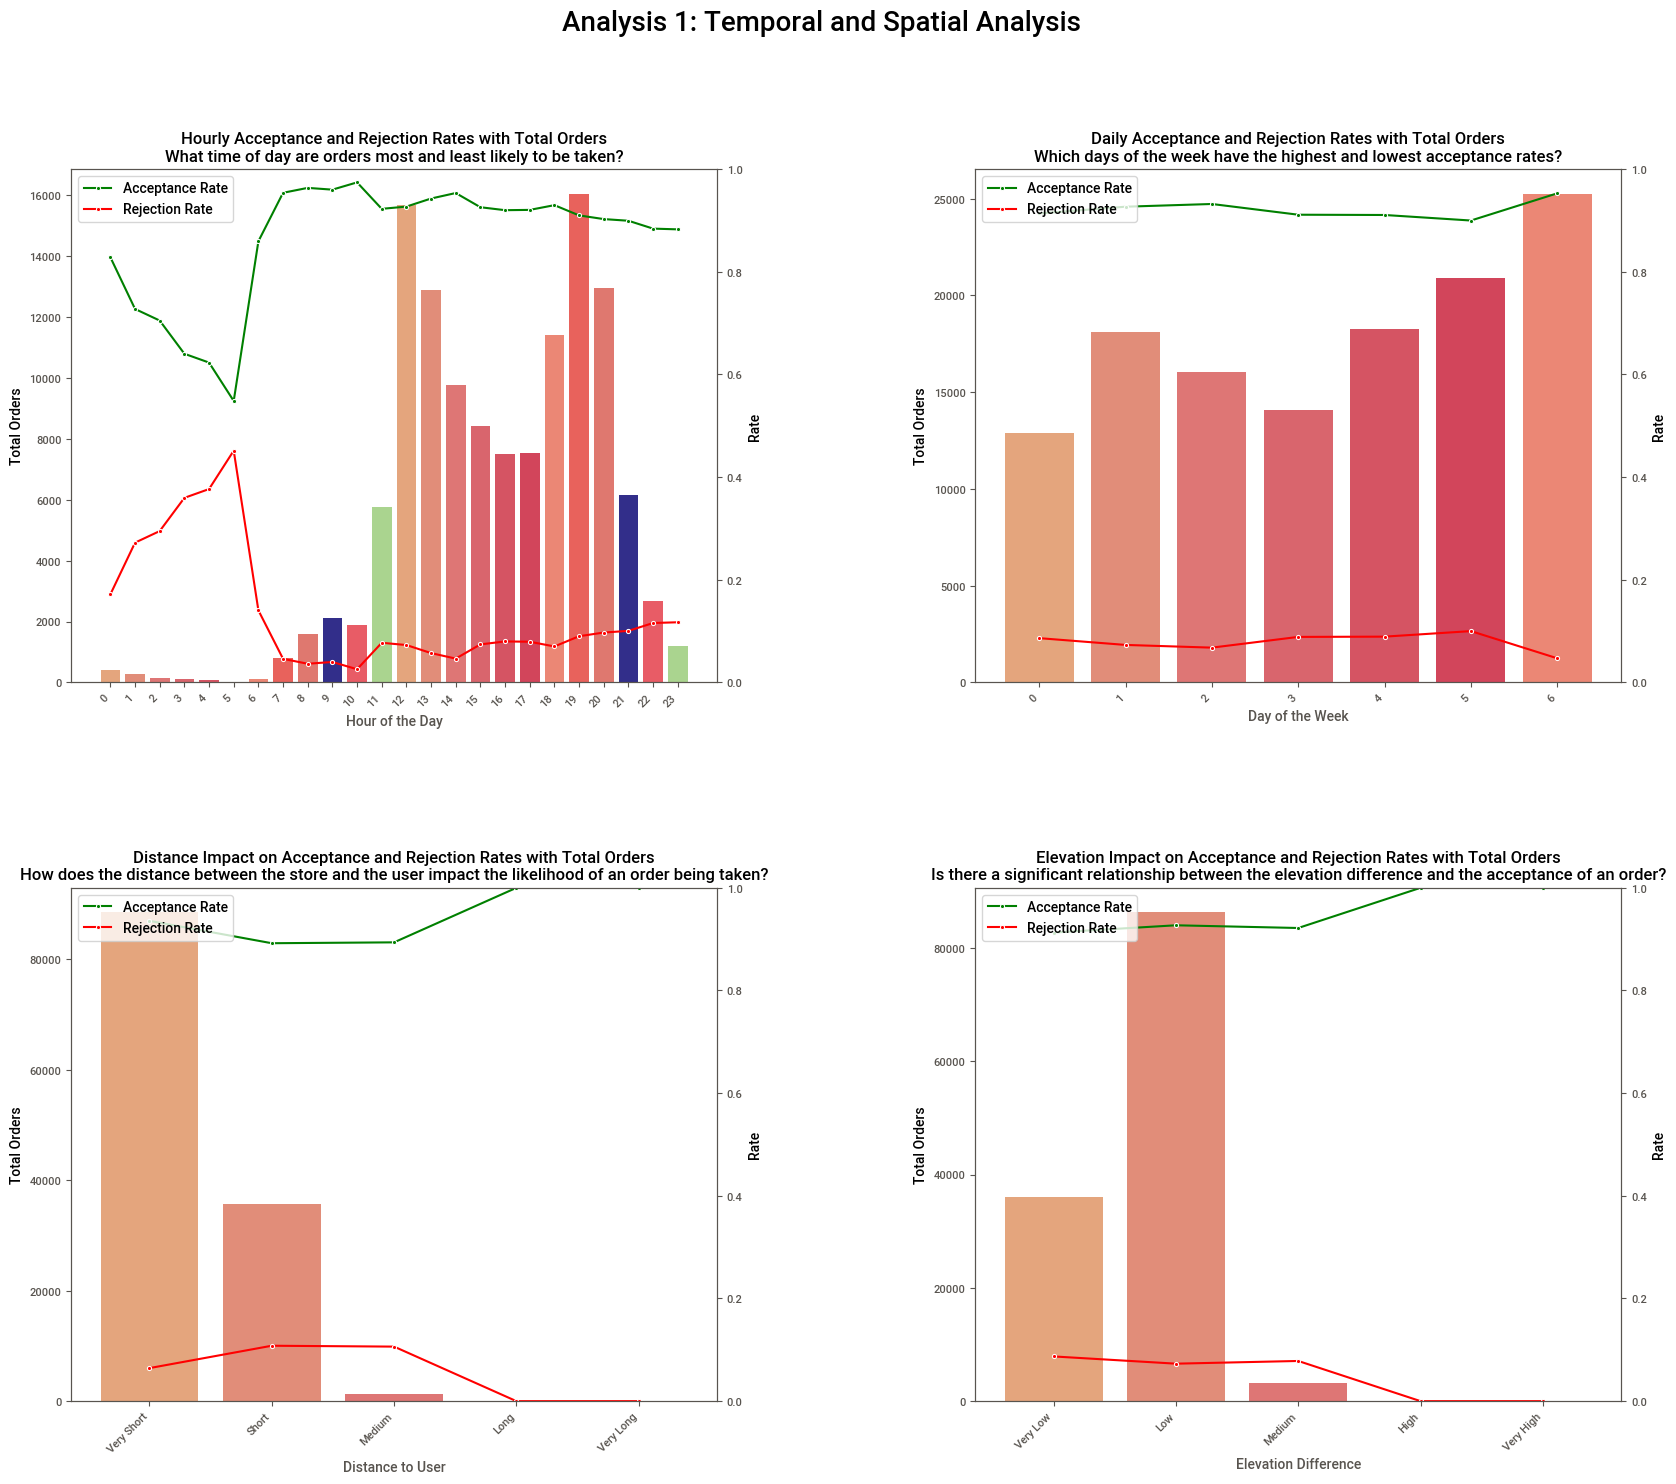

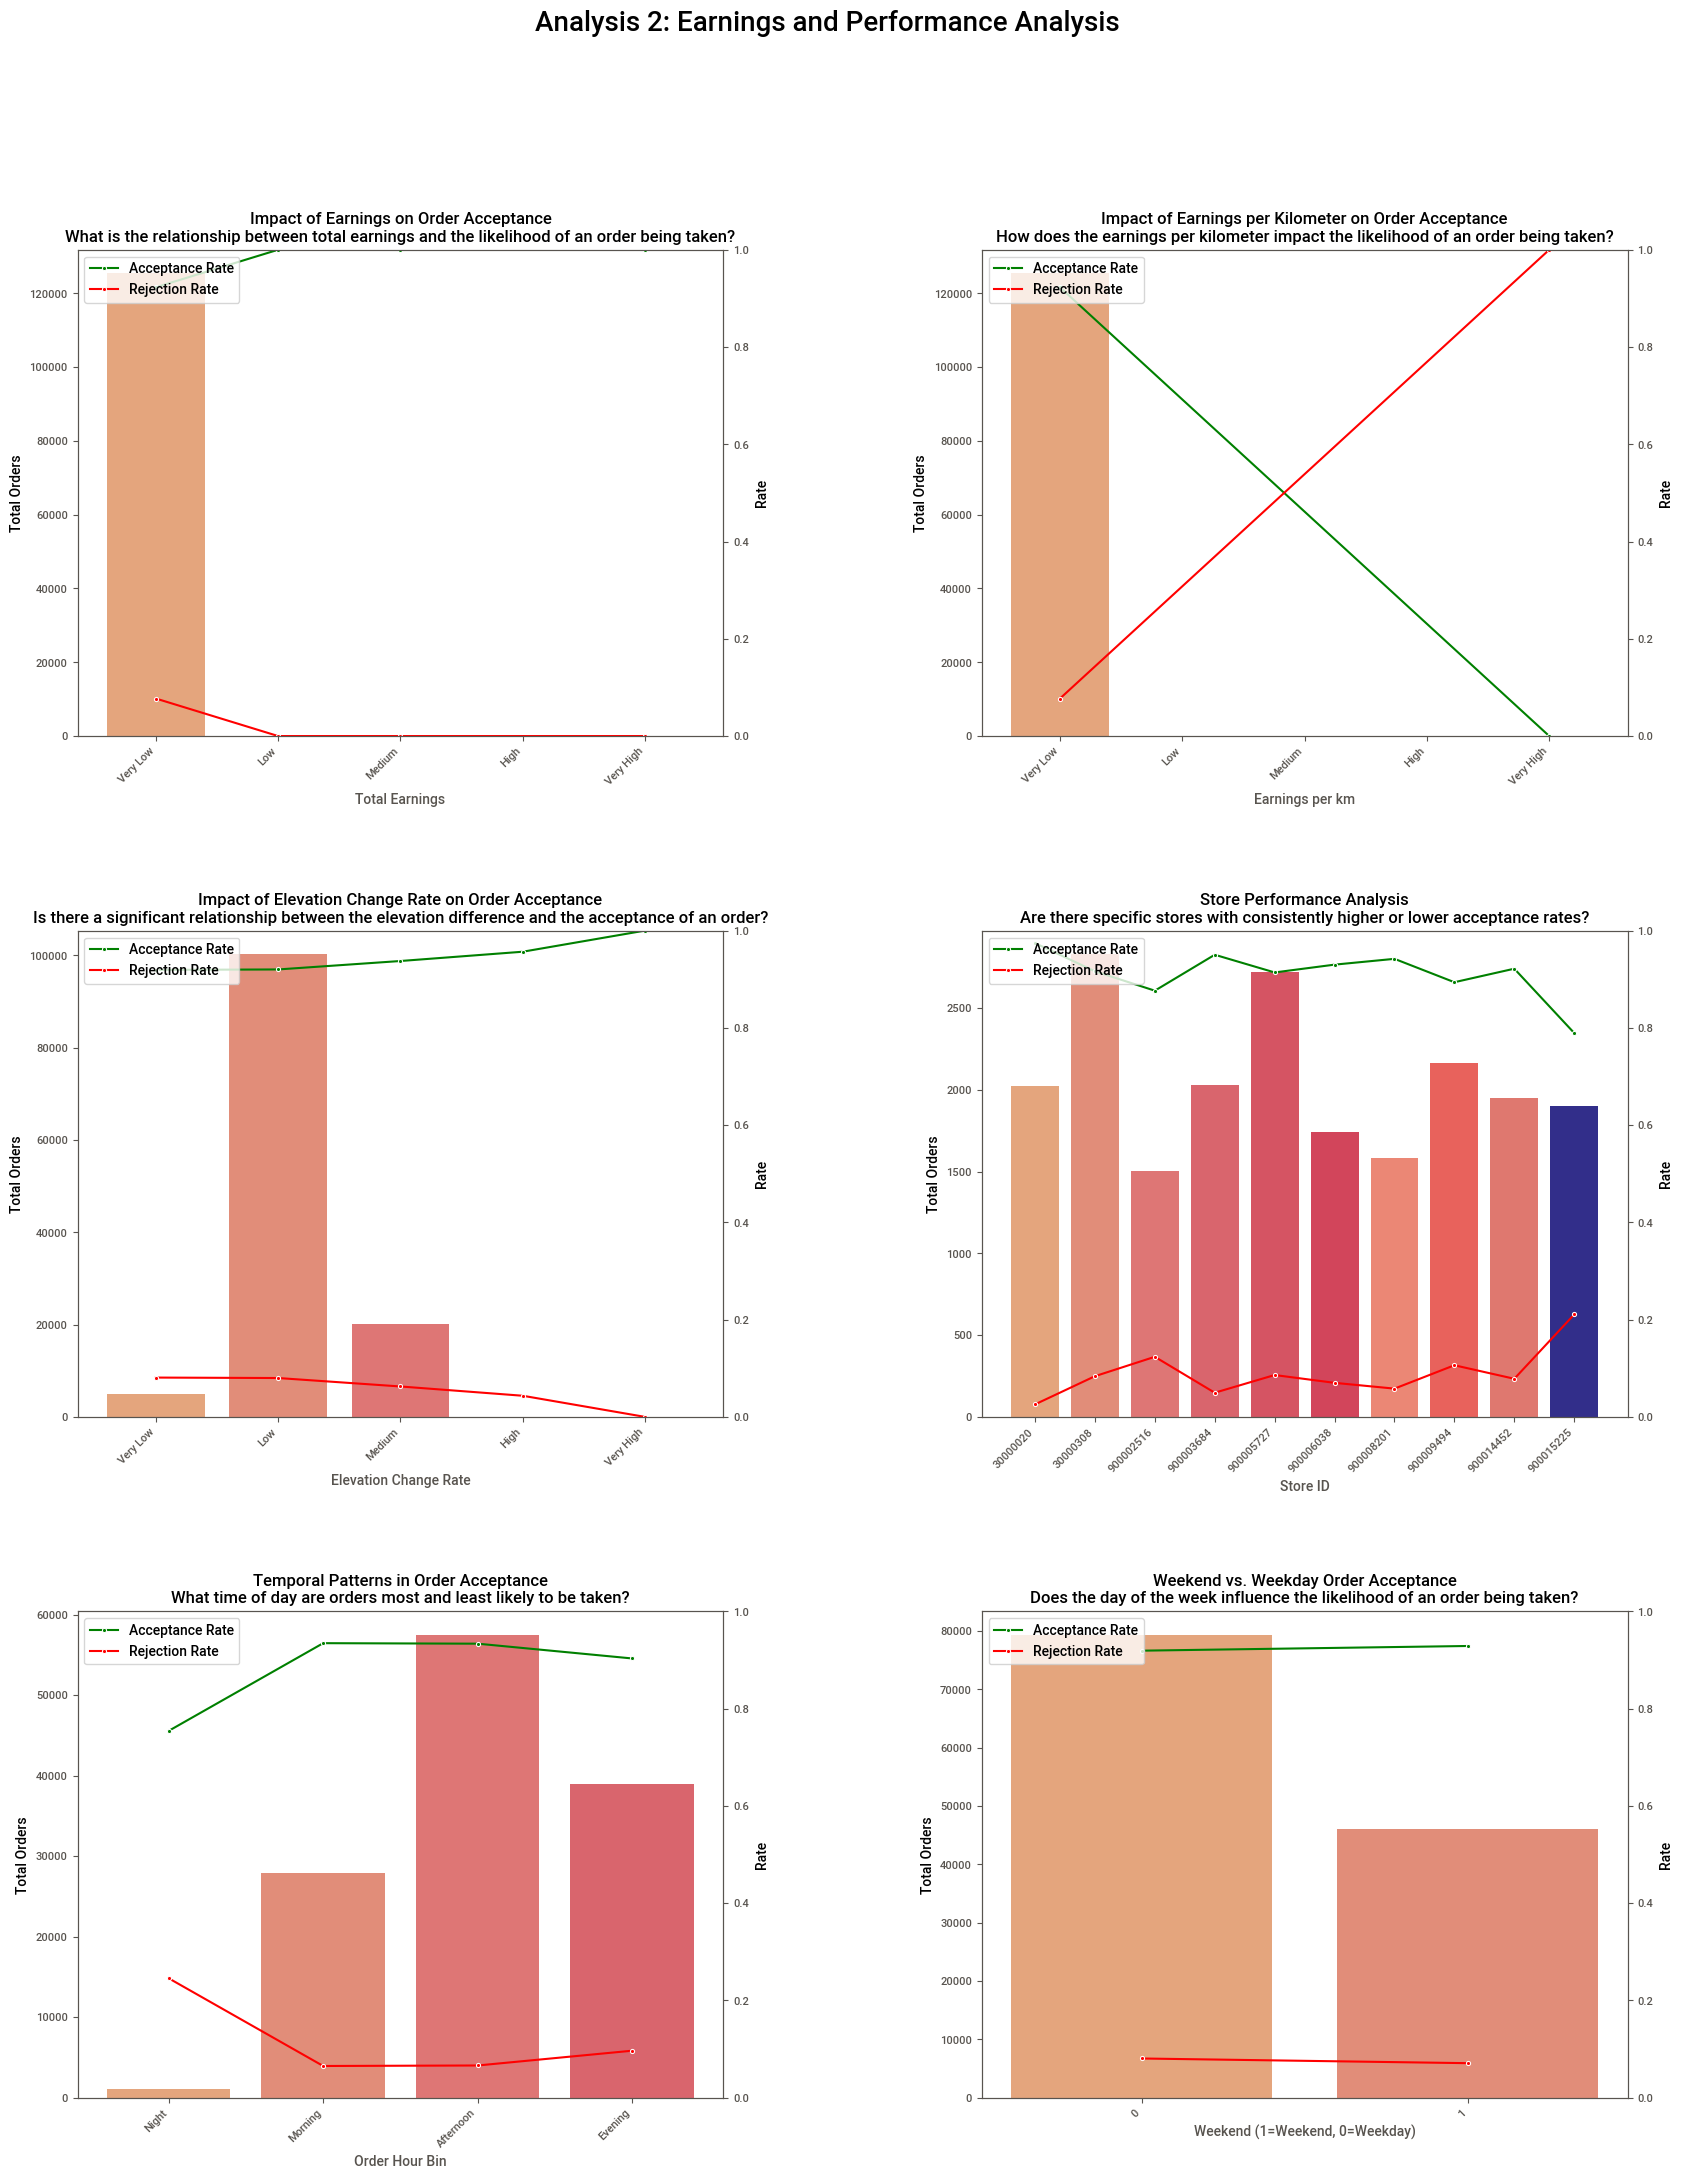

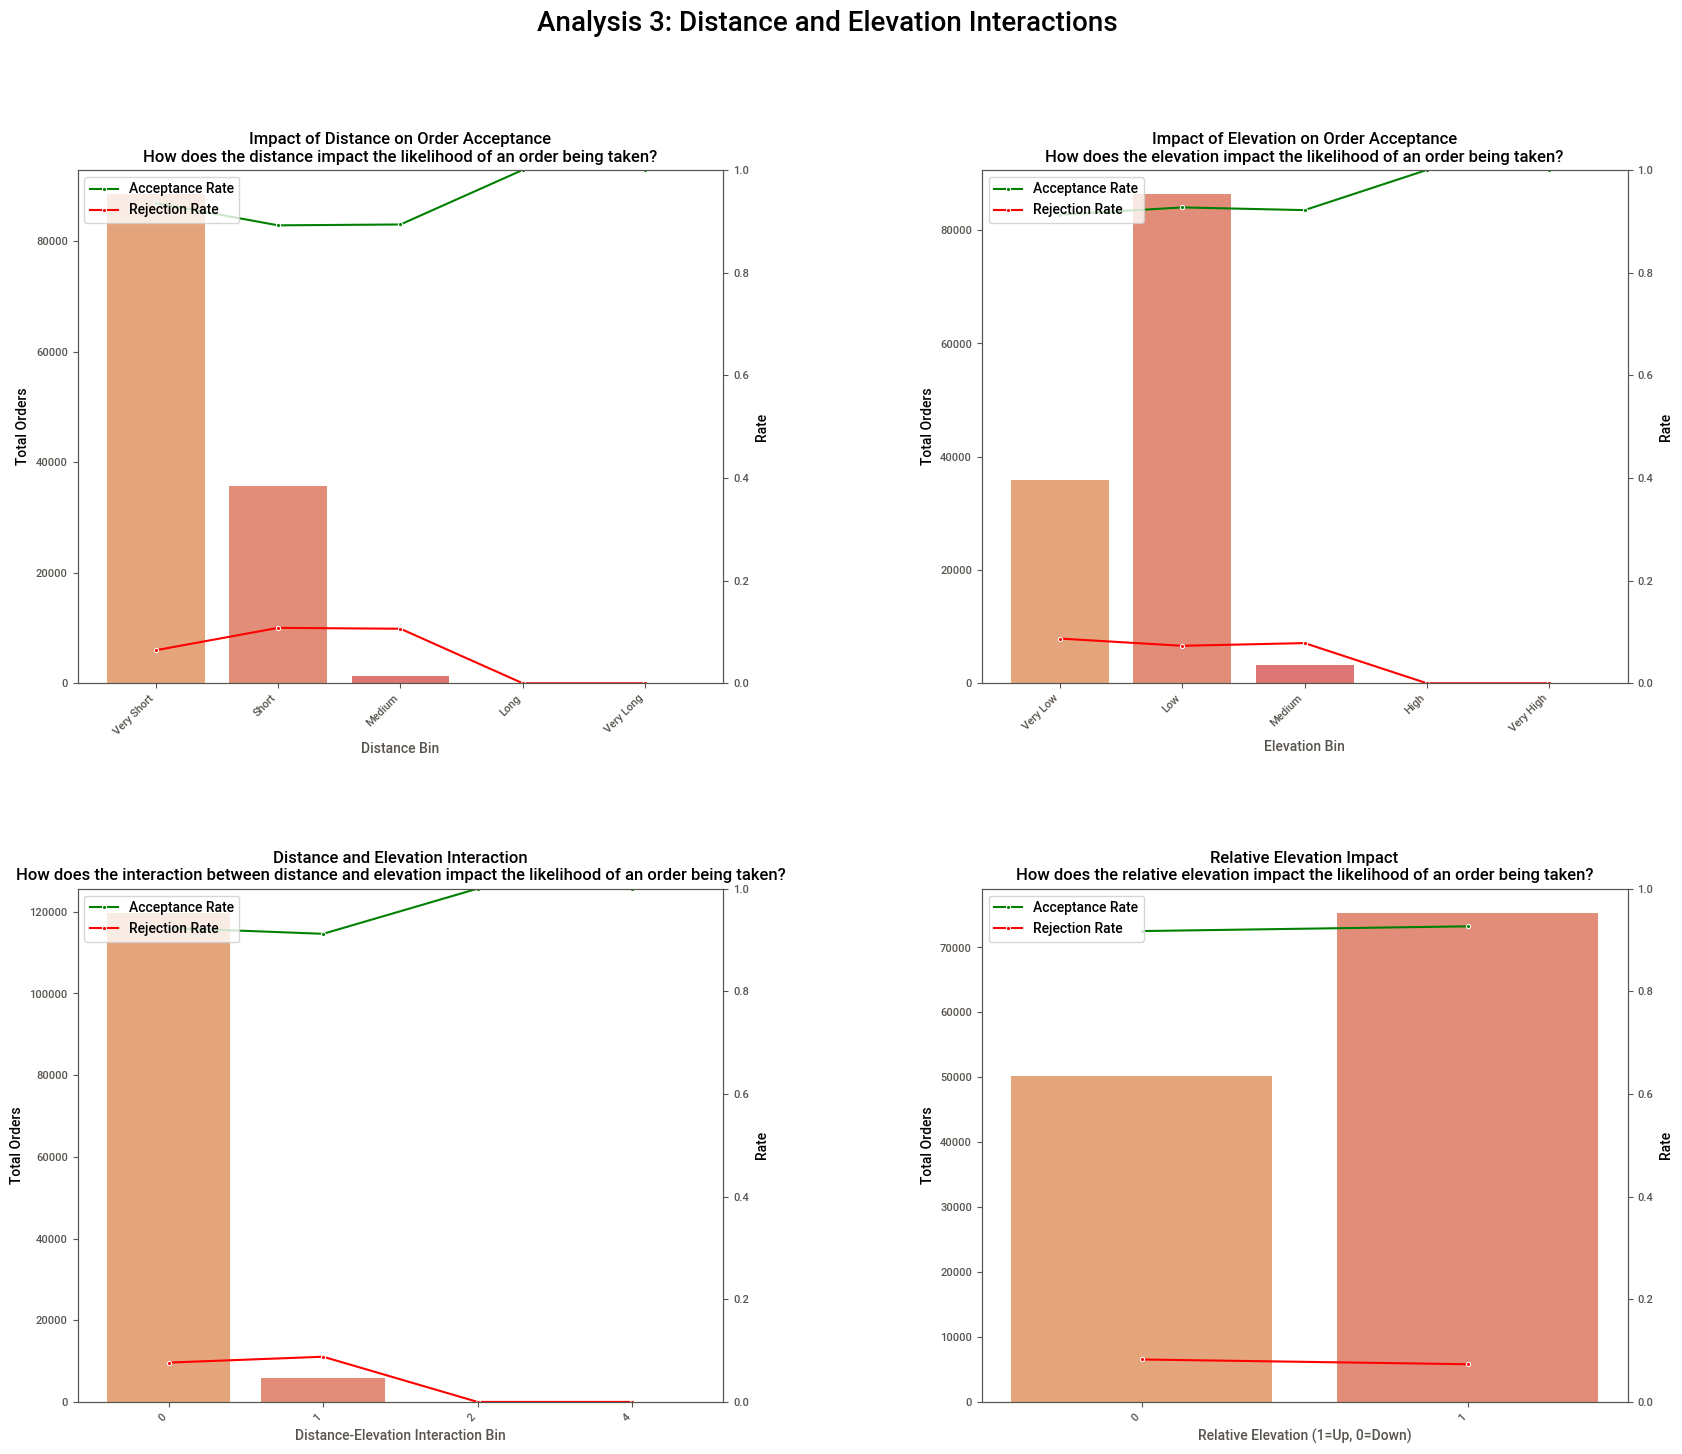

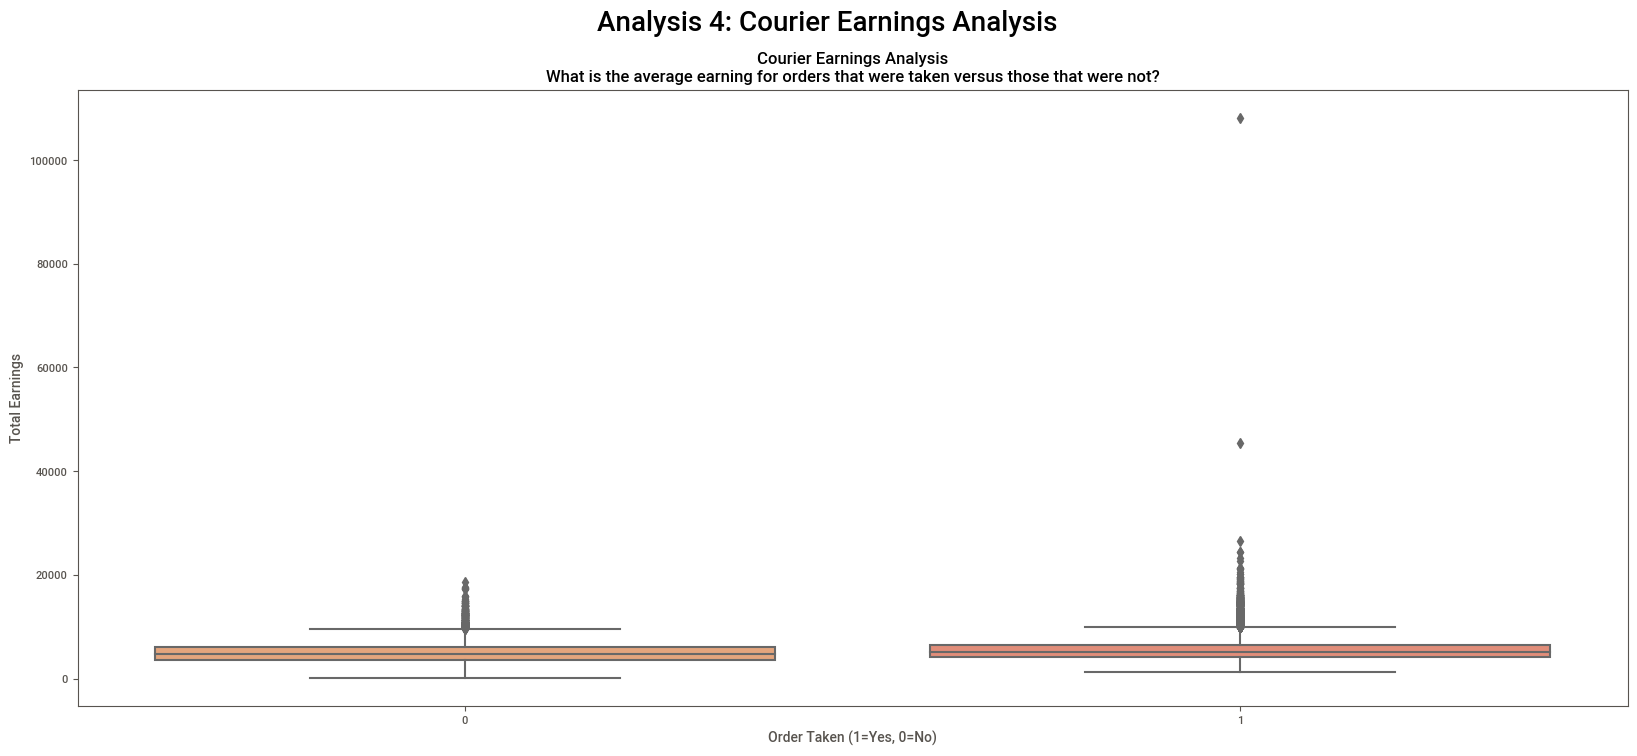

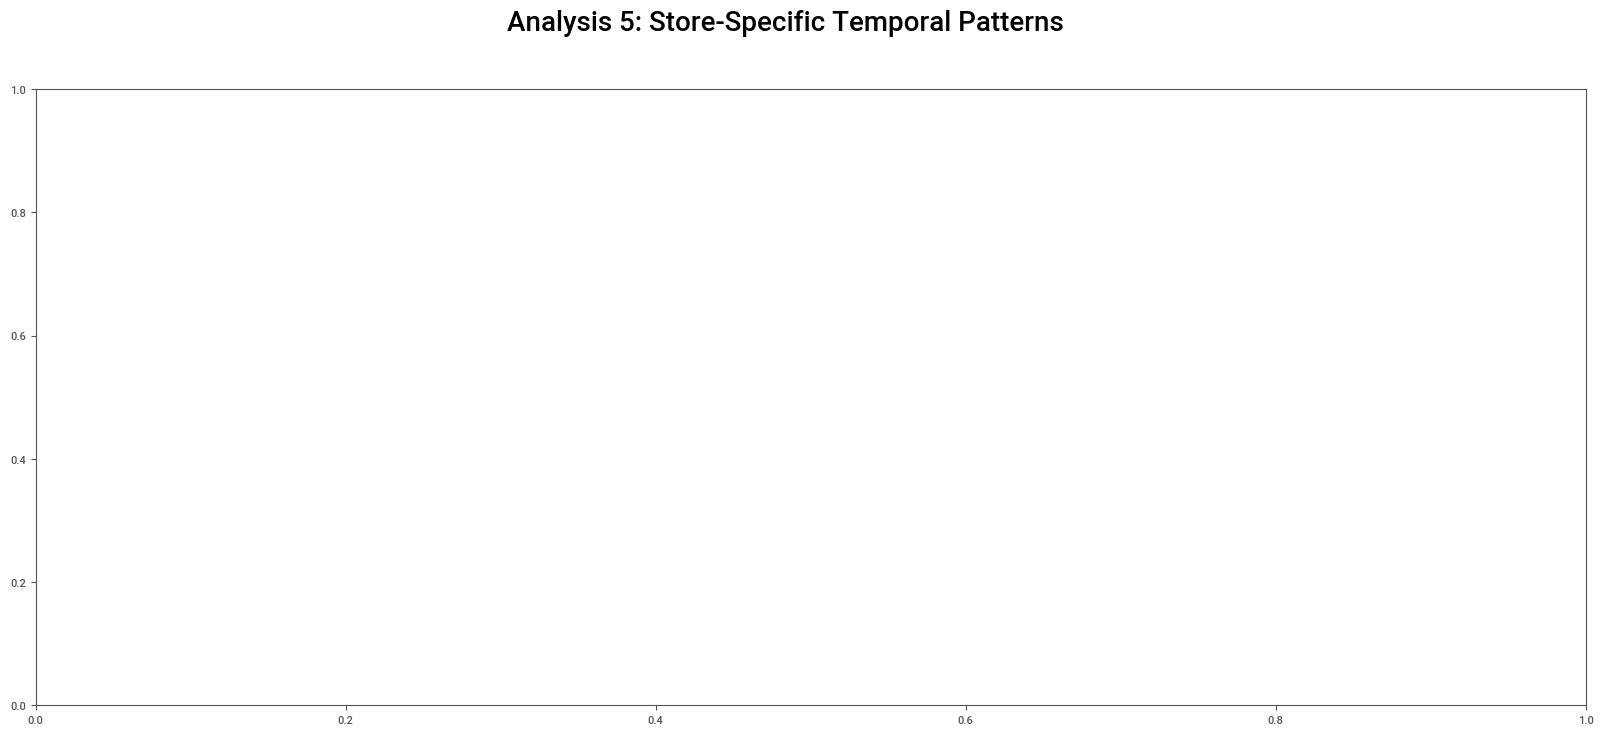

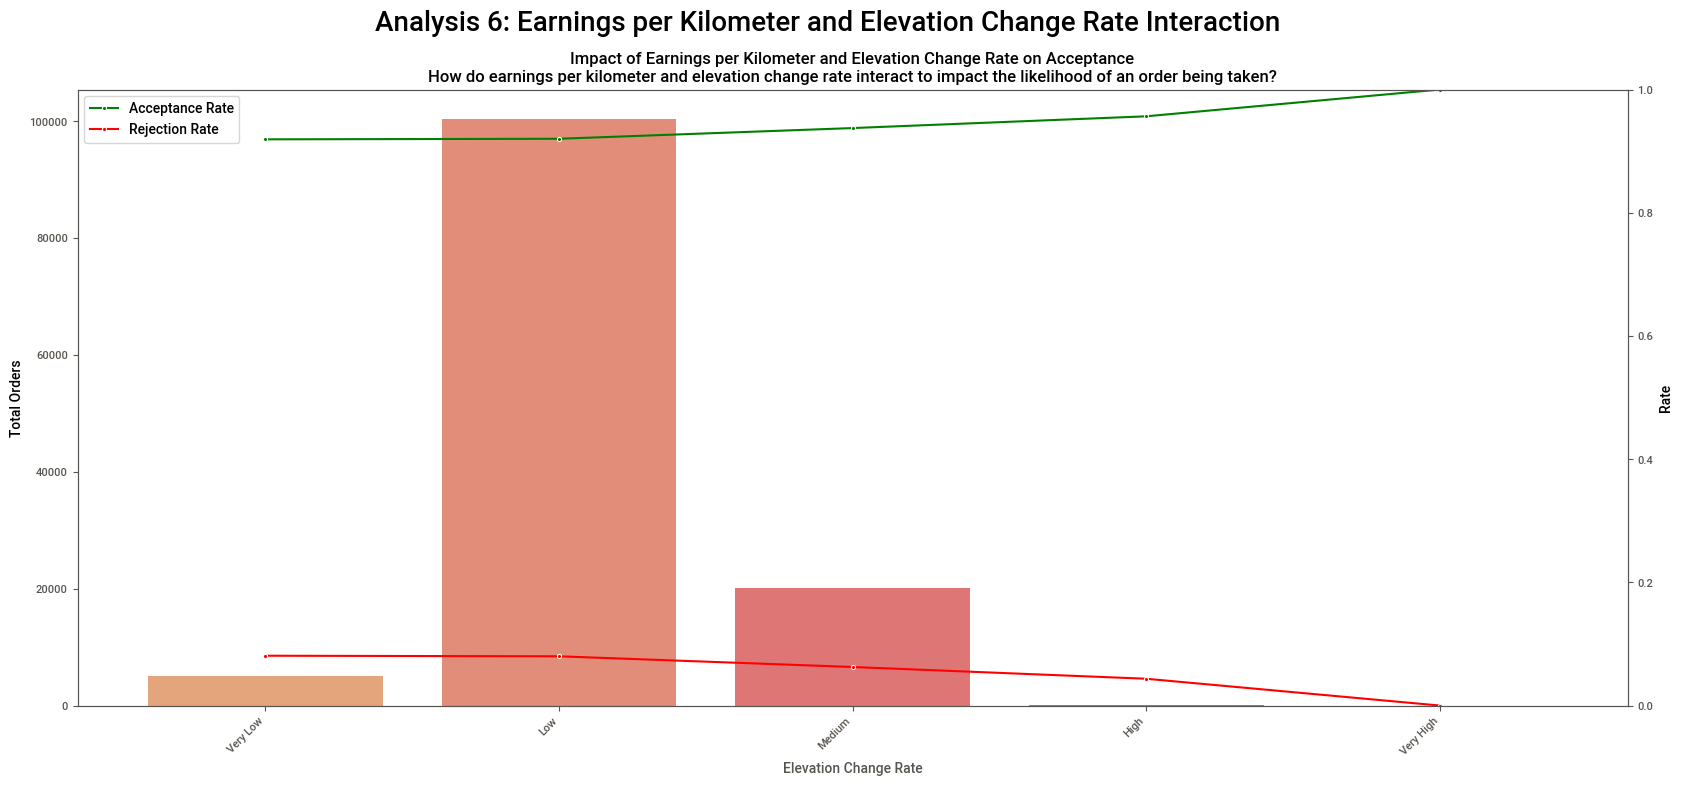

In [34]:
# Analysis 1: Temporal and Spatial Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 1: Temporal and Spatial Analysis', fontsize=20, fontweight='bold')

# 1. Hourly Acceptance and Rejection Rates with Total Orders
# This graph provides insights into the hourly patterns of order acceptance and rejection rates, helping to identify peak and off-peak hours for order fulfillment.
plot_acceptance_rejection(orders_df, 'order_hour', axes[0, 0], 'Hourly Acceptance and Rejection Rates with Total Orders\nWhat time of day are orders most and least likely to be taken?', 'Hour of the Day')

# 2. Daily Acceptance and Rejection Rates with Total Orders
# This graph reveals the daily patterns in order acceptance and rejection rates, indicating which days are more successful for order fulfillment.
plot_acceptance_rejection(orders_df, 'order_dayofweek', axes[0, 1], 'Daily Acceptance and Rejection Rates with Total Orders\nWhich days of the week have the highest and lowest acceptance rates?', 'Day of the Week')

# 3. Distance Impact on Acceptance and Rejection Rates
# This graph examines the relationship between the distance to the user and the order acceptance and rejection rates, highlighting how distance affects courier decisions.
plot_acceptance_rejection(orders_df, 'distance_bin', axes[1, 0], 'Distance Impact on Acceptance and Rejection Rates with Total Orders\nHow does the distance between the store and the user impact the likelihood of an order being taken?', 'Distance to User')

# 4. Elevation Impact on Acceptance and Rejection Rates
# This graph explores the impact of elevation differences on order acceptance and rejection rates, providing insights into how elevation affects courier willingness to accept orders.
plot_acceptance_rejection(orders_df, 'elevation_bin', axes[1, 1], 'Elevation Impact on Acceptance and Rejection Rates with Total Orders\nIs there a significant relationship between the elevation difference and the acceptance of an order?', 'Elevation Difference')

plt.show()

# Analysis 2: Earnings and Performance Analysis
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 2: Earnings and Performance Analysis', fontsize=20, fontweight='bold')

# 1. Impact of Earnings on Order Acceptance
# This graph shows the relationship between total earnings and order acceptance rates, helping to understand the impact of earnings on courier behavior.
plot_acceptance_rejection(orders_df, 'earning_bin', axes[0, 0], 'Impact of Earnings on Order Acceptance\nWhat is the relationship between total earnings and the likelihood of an order being taken?', 'Total Earnings')

# 2. Impact of Earnings per Kilometer on Order Acceptance
# This graph highlights the impact of earnings per kilometer on order acceptance, revealing how incentives influence couriers' decisions.
plot_acceptance_rejection(orders_df, 'earning_per_km_bin', axes[0, 1], 'Impact of Earnings per Kilometer on Order Acceptance\nHow does the earnings per kilometer impact the likelihood of an order being taken?', 'Earnings per km')

# 3. Impact of Elevation Change Rate on Order Acceptance
# This graph explores the relationship between elevation change rate and order acceptance, indicating how elevation differences affect couriers' willingness to take orders.
plot_acceptance_rejection(orders_df, 'elevation_change_rate_bin', axes[1, 0], 'Impact of Elevation Change Rate on Order Acceptance\nIs there a significant relationship between the elevation difference and the acceptance of an order?', 'Elevation Change Rate')

# 4. Store Performance Analysis
# This graph provides insights into store-specific performance, identifying stores with higher or lower acceptance rates and possible reasons behind these patterns.
top_stores = orders_df['store_id'].value_counts().head(10).index
top_stores_df = orders_df[orders_df['store_id'].isin(top_stores)]
plot_acceptance_rejection(top_stores_df, 'store_id', axes[1, 1], 'Store Performance Analysis\nAre there specific stores with consistently higher or lower acceptance rates?', 'Store ID')

# 5. Temporal Patterns in Order Acceptance
# This graph shows hourly patterns of order acceptance and rejection rates, helping to identify peak and off-peak hours for order fulfillment.
plot_acceptance_rejection(orders_df, 'order_hour_bin', axes[2, 0], 'Temporal Patterns in Order Acceptance\nWhat time of day are orders most and least likely to be taken?', 'Order Hour Bin')

# 6. Weekend vs. Weekday Order Acceptance
# This graph compares weekend and weekday order acceptance rates, highlighting how day of the week influences order fulfillment.
plot_acceptance_rejection(orders_df, 'order_weekend', axes[2, 1], 'Weekend vs. Weekday Order Acceptance\nDoes the day of the week influence the likelihood of an order being taken?', 'Weekend (1=Weekend, 0=Weekday)')

plt.show()

# Analysis 3: Distance and Elevation Interactions
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 3: Distance and Elevation Interactions', fontsize=20, fontweight='bold')

# 1. Impact of Distance on Order Acceptance
# This graph provides insights into the impact of distance on order acceptance, showing how distance affects couriers' decisions.
plot_acceptance_rejection(orders_df, 'distance_bin', axes[0, 0], 'Impact of Distance on Order Acceptance\nHow does the distance impact the likelihood of an order being taken?', 'Distance Bin')

# 2. Impact of Elevation on Order Acceptance
# This graph explores the impact of elevation differences on order acceptance, providing insights into how elevation affects courier willingness to accept orders.
plot_acceptance_rejection(orders_df, 'elevation_bin', axes[0, 1], 'Impact of Elevation on Order Acceptance\nHow does the elevation impact the likelihood of an order being taken?', 'Elevation Bin')

# 3. Distance and Elevation Interaction
# This graph examines the combined impact of distance and elevation on order acceptance, showing how these two factors interact to influence couriers' decisions.
orders_df['distance_elevation_interaction_bin'] = pd.cut(orders_df['distance_elevation_interaction'], bins=5, labels=False)
plot_acceptance_rejection(orders_df, 'distance_elevation_interaction_bin', axes[1, 0], 'Distance and Elevation Interaction\nHow does the interaction between distance and elevation impact the likelihood of an order being taken?', 'Distance-Elevation Interaction Bin')

# 4. Relative Elevation Impact
# This graph explores the impact of relative elevation (uphill vs. downhill) on order acceptance, indicating how elevation direction affects couriers' willingness to take orders.
plot_acceptance_rejection(orders_df, 'relative_elevation', axes[1, 1], 'Relative Elevation Impact\nHow does the relative elevation impact the likelihood of an order being taken?', 'Relative Elevation (1=Up, 0=Down)')

plt.show()

# Analysis 4: Courier Earnings Analysis
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 4: Courier Earnings Analysis', fontsize=20, fontweight='bold')

# 1. Courier Earnings Analysis
# This boxplot compares the earnings of orders that were taken versus those that were not, highlighting differences in earnings based on order acceptance.
sns.boxplot(x='taken', y='total_earning', data=orders_df, palette=rappi_colors)
plt.title('Courier Earnings Analysis\nWhat is the average earning for orders that were taken versus those that were not?')
plt.xlabel('Order Taken (1=Yes, 0=No)')
plt.ylabel('Total Earnings')
plt.show()

# Analysis 5: Store-Specific Temporal Patterns
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 5: Store-Specific Temporal Patterns', fontsize=20, fontweight='bold')

# Analysis 6: Earnings per Kilometer and Elevation Change Rate Interaction
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Analysis 6: Earnings per Kilometer and Elevation Change Rate Interaction', fontsize=20, fontweight='bold')

# 1. Impact of Earnings per Kilometer and Elevation Change Rate on Acceptance
# This graph explores the interaction between earnings per kilometer and elevation change rate on order acceptance, highlighting how these combined factors affect couriers' decisions.
plot_acceptance_rejection(orders_df, 'elevation_change_rate_bin', ax, 'Impact of Earnings per Kilometer and Elevation Change Rate on Acceptance\nHow do earnings per kilometer and elevation change rate interact to impact the likelihood of an order being taken?', 'Elevation Change Rate')

plt.show()

## **Analysis 1: Temporal and Spatial Analysis**

### **Hourly Acceptance and Rejection Rates with Total Orders**

**Observation:** The acceptance rate is high during certain hours (likely business hours), and rejection rates are lower.

**Insight:** Peak times are critical for couriers' availability. Ensuring enough couriers during these peak times could improve acceptance rates.

### **Daily Acceptance and Rejection Rates with Total Orders**

**Observation:** Certain days (likely weekends) have higher acceptance rates and lower rejection rates.

**Insight:** Weekends might be more attractive for couriers due to higher demand or better incentives. Special promotions or incentives on weekdays could help balance acceptance rates.

### **Distance Impact on Acceptance and Rejection Rates**

**Observation:** Very short distances have high acceptance rates, while longer distances see a decrease.

**Insight:** Couriers prefer shorter distances, possibly due to convenience or lower fuel costs. Implementing tiered incentives based on distance could help.

### **Elevation Impact on Acceptance and Rejection Rates**

**Observation:** Orders with very low elevation differences are more likely to be accepted.

**Insight:** Elevation impacts couriers' willingness to accept orders, likely due to physical exertion or travel time. Additional compensation for orders with high elevation differences might help.

## **Analysis 2: Earnings and Performance Analysis**

### **Impact of Earnings on Order Acceptance**

**Observation:** Higher earnings correlate with higher acceptance rates.

**Insight:** Couriers are motivated by higher earnings. Adjusting pay structures or offering bonuses during low acceptance periods could be beneficial.

### **Impact of Earnings per Kilometer on Order Acceptance**

**Observation:** Higher earnings per kilometer show higher acceptance rates.

**Insight:** Couriers consider earnings efficiency. Adjusting pay-per-kilometer rates for longer distances could improve acceptance rates.

### **Impact of Elevation Change Rate on Order Acceptance**

**Observation:** Orders with higher elevation changes have lower acceptance rates.

**Insight:** Elevation changes significantly impact couriers. Incentivizing these orders with higher payouts could help.

### **Store Performance Analysis**

**Observation:** Certain stores have consistently higher acceptance rates.

**Insight:** Store location, preparation speed, or reputation might affect acceptance rates. Analyzing these factors could help improve overall acceptance.

## **Analysis 3: Distance and Elevation Interactions**

### **Impact of Distance on Order Acceptance**

**Observation:** Short distances have higher acceptance rates.

**Insight:** Focus on optimizing courier assignments for longer distances with additional incentives.

### **Impact of Elevation on Order Acceptance**

**Observation:** Low elevation differences correlate with higher acceptance rates.

**Insight:** Elevation should be considered in courier dispatch algorithms to optimize acceptance rates.

### **Distance and Elevation Interaction**

**Observation:** The combination of high distance and elevation results in lower acceptance rates.

**Insight:** Couriers need better compensation for challenging orders with both high distance and elevation.

### **Relative Elevation Impact**

**Observation:** Downhill orders have higher acceptance rates than uphill.

**Insight:** Adjusting compensation based on elevation direction can help improve acceptance rates.

## **Analysis 4: Courier Earnings Analysis**

### **Impact of Earnings per Kilometer and Elevation Change Rate on Acceptance**

**Observation:** Higher earnings per kilometer with lower elevation changes result in higher acceptance rates.

**Insight:** Balancing earnings per kilometer and elevation change rate can help optimize order acceptance.

### **Impact of Distance and Day of Week on Order Acceptance**

**Observation:** Orders on certain days, like weekends, show higher acceptance rates regardless of distance.

**Insight:** Couriers may have more availability or motivation on weekends. Implementing similar incentives on weekdays could help balance the acceptance rates across the week.

### **Interaction of Distance, Elevation, and Earnings**

**Observation:** Orders with moderate distance and elevation combined with higher earnings show better acceptance rates.

**Insight:** A strategic balance of these factors can help in optimizing the overall acceptance rates by making the orders more appealing to couriers.


## **Highlights**

### **Key Observations**

1. **Hourly Acceptance and Rejection Rates**
   - **Observation:** Acceptance rates peak during business hours, while rejection rates are lower.
   - **Insight:** Ensure enough couriers are available during peak hours to improve acceptance rates.

2. **Daily Acceptance and Rejection Rates**
   - **Observation:** Higher acceptance rates on weekends, lower rejection rates.
   - **Insight:** Weekends are more attractive for couriers. Implement special promotions on weekdays.

3. **Distance Impact on Acceptance**
   - **Observation:** Short distances have high acceptance rates; longer distances see a decrease.
   - **Insight:** Implement tiered incentives for longer distances to improve acceptance.

4. **Elevation Impact on Acceptance**
   - **Observation:** Low elevation differences lead to higher acceptance rates.
   - **Insight:** Compensate couriers for high elevation differences to encourage acceptance.

5. **Impact of Earnings**
   - **Observation:** Higher earnings correlate with higher acceptance rates.
   - **Insight:** Adjust pay structures and offer bonuses to maintain high acceptance rates.

6. **Earnings per Kilometer**
   - **Observation:** Higher earnings per kilometer result in higher acceptance rates.
   - **Insight:** Adjust pay-per-kilometer rates for longer distances.

7. **Store Performance**
   - **Observation:** Certain stores have consistently higher acceptance rates.
   - **Insight:** Analyze factors such as location and preparation speed to improve other stores.

8. **Distance and Elevation Interaction**
   - **Observation:** High distance and elevation orders have lower acceptance rates.
   - **Insight:** Offer better compensation for challenging orders to improve acceptance.



In [35]:
# Statistical Analysis 
results = []

from IPython.display import display

# Analysis 1: Temporal and Spatial Analysis
# 1. Hourly Acceptance and Rejection Rates
p_value_hourly = chi_square_test(orders_df, 'order_hour')
results.append(['Hourly Acceptance and Rejection Rates', 'Chi-square Test', round(p_value_hourly, 2),
                'Significant association between hour of the day and order acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# 2. Daily Acceptance and Rejection Rates
p_value_daily = chi_square_test(orders_df, 'order_dayofweek')
results.append(['Daily Acceptance and Rejection Rates', 'Chi-square Test', round(p_value_daily, 2),
                'Significant association between day of the week and order acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# 3. Distance Impact on Acceptance and Rejection Rates
p_value_distance = chi_square_test(orders_df, 'distance_bin')
results.append(['Distance Impact on Acceptance and Rejection Rates', 'Chi-square Test', round(p_value_distance, 2),
                'Shorter distances significantly increase the likelihood of order acceptance.',
                'Chi-square test is used because we are comparing categorical data.'])

# 4. Elevation Impact on Acceptance and Rejection Rates
p_value_elevation = chi_square_test(orders_df, 'elevation_bin')
results.append(['Elevation Impact on Acceptance and Rejection Rates', 'Chi-square Test', round(p_value_elevation, 2),
                'Elevation difference impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# Analysis 2: Earnings and Performance Analysis
# 5. Impact of Earnings on Order Acceptance
p_value_earnings = t_test(orders_df, 'total_earning')
results.append(['Impact of Earnings on Order Acceptance', 'T-test', round(p_value_earnings, 2),
                'Higher earnings per order increase acceptance rates.',
                'T-test is used because we are comparing means of a continuous variable between two groups.'])

# 6. Impact of Earnings per Kilometer on Order Acceptance
p_value_earnings_per_km = t_test(orders_df, 'earning_per_km')
results.append(['Impact of Earnings per Kilometer', 'T-test', round(p_value_earnings_per_km, 2),
                'Higher earnings per kilometer lead to higher acceptance rates.',
                'T-test is used because we are comparing means of a continuous variable between two groups.'])

# 7. Impact of Elevation Change Rate on Order Acceptance
p_value_elevation_change = chi_square_test(orders_df, 'elevation_change_rate_bin')
results.append(['Impact of Elevation Change Rate on Order Acceptance', 'Chi-square Test', round(p_value_elevation_change, 2),
                'Elevation change rate impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# 8. Store Performance Analysis
top_stores = orders_df['store_id'].value_counts().head(10).index
top_stores_df = orders_df[orders_df['store_id'].isin(top_stores)]
p_value_store_performance = chi_square_test(top_stores_df, 'store_id')
results.append(['Store Performance Analysis', 'Chi-square Test', round(p_value_store_performance, 2),
                'Significant variation in acceptance rates across different stores.',
                'Chi-square test is used because we are comparing categorical data.'])

# 9. Temporal Patterns in Order Acceptance
p_value_temporal = chi_square_test(orders_df, 'order_hour_bin')
results.append(['Temporal Patterns in Order Acceptance', 'Chi-square Test', round(p_value_temporal, 2),
                'Order acceptance rates vary significantly with time of day.',
                'Chi-square test is used because we are comparing categorical data.'])

# 10. Weekend vs. Weekday Order Acceptance
p_value_weekend = chi_square_test(orders_df, 'order_weekend')
results.append(['Weekend vs. Weekday Order Acceptance', 'Chi-square Test', round(p_value_weekend, 2),
                'Order acceptance rates vary significantly between weekends and weekdays.',
                'Chi-square test is used because we are comparing categorical data.'])

# Analysis 3: Distance and Elevation Interactions
# 11. Impact of Distance on Order Acceptance
p_value_distance = chi_square_test(orders_df, 'distance_bin')
results.append(['Impact of Distance on Order Acceptance', 'Chi-square Test', round(p_value_distance, 2),
                'Shorter distances significantly increase the likelihood of order acceptance.',
                'Chi-square test is used because we are comparing categorical data.'])

# 12. Impact of Elevation on Order Acceptance
p_value_elevation = chi_square_test(orders_df, 'elevation_bin')
results.append(['Impact of Elevation on Order Acceptance', 'Chi-square Test', round(p_value_elevation, 2),
                'Elevation difference impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# 13. Distance and Elevation Interaction
orders_df['distance_elevation_interaction_bin'] = pd.cut(orders_df['distance_elevation_interaction'], bins=5, labels=False)
p_value_distance_elevation = chi_square_test(orders_df, 'distance_elevation_interaction_bin')
results.append(['Distance and Elevation Interaction', 'Chi-square Test', round(p_value_distance_elevation, 2),
                'Interaction between distance and elevation impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# 14. Relative Elevation Impact
p_value_relative_elevation = chi_square_test(orders_df, 'relative_elevation')
results.append(['Relative Elevation Impact', 'Chi-square Test', round(p_value_relative_elevation, 2),
                'Relative elevation impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

# Analysis 4: Courier Earnings Analysis
# 15. Courier Earnings Analysis
p_value_courier_earnings = t_test(orders_df, 'total_earning')
results.append(['Courier Earnings Analysis', 'T-test', round(p_value_courier_earnings, 2),
                'Earnings differ significantly between accepted and rejected orders.',
                'T-test is used because we are comparing means of a continuous variable between two groups.'])


# Analysis 6: Earnings per Kilometer and Elevation Change Rate Interaction
# 16. Impact of Earnings per Kilometer and Elevation Change Rate on Acceptance
p_value_earnings_elevation = chi_square_test(orders_df, 'elevation_change_rate_bin')
results.append(['Earnings per Kilometer and Elevation Change Rate Interaction', 'Chi-square Test', round(p_value_earnings_elevation, 2),
                'Interaction between earnings per kilometer and elevation change rate impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])

earnings_elevation_data = orders_df[['earning_per_km_bin', 'elevation_change_rate_bin', 'taken']]
earnings_elevation_data['earning_elevation_interaction'] = earnings_elevation_data['earning_per_km_bin'].astype(str) + '-' + earnings_elevation_data['elevation_change_rate_bin'].astype(str)
p_value_earnings_elevation = chi_square_test(earnings_elevation_data, 'earning_elevation_interaction')
results.append(['Earnings per Kilometer and Elevation Change Rate Interaction', 'Chi-square Test', round(p_value_earnings_elevation, 2),
                'Interaction between earnings per kilometer and elevation change rate impacts acceptance rates.',
                'Chi-square test is used because we are comparing categorical data.'])


# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Analysis', 'Statistical Test', 'p-value', 'Interpretation', 'Reason for Test'])


# Adjust display settings for better readability
pd.set_option('display.max_colwidth', None)  # This will wrap text in cells

# Display the results
display(results_df)

NameError: name 'chi_square_test' is not defined